In [1]:
# First, import the necessary databases

In [2]:
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import train_test_split, cross_validate, StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, LeaveOneOut, StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, make_scorer, roc_curve
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from scipy import stats
from sklearn.metrics import roc_auc_score

In [3]:
# Read csv file (censored)
df = pd.read_csv('final_dataframe')

Results for KNN:
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}
Mean accuracy: 0.8708860759493671
Mean precision: 0.8751683172172952
Mean recall: 0.8708860759493671
Mean F1-score: 0.8599645013823018
Mean ROC AUC: 0.848219642396321
Results for Decision Tree:
Best Parameters: {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 10}
Mean accuracy: 0.8662447257383967
Mean precision: 0.8624581455038882
Mean recall: 0.8662447257383967
Mean F1-score: 0.861085868249494
Mean ROC AUC: 0.8367498848691153
Results for Random Forest:
Best Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Mean accuracy: 0.8831223628691983
Mean precision: 0.8865475345480472
Mean recall: 0.8831223628691983
Mean F1-score: 0.8744911075771533
Mean ROC AUC: 0.884543626807066
Results for XGBoost:
Best Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth

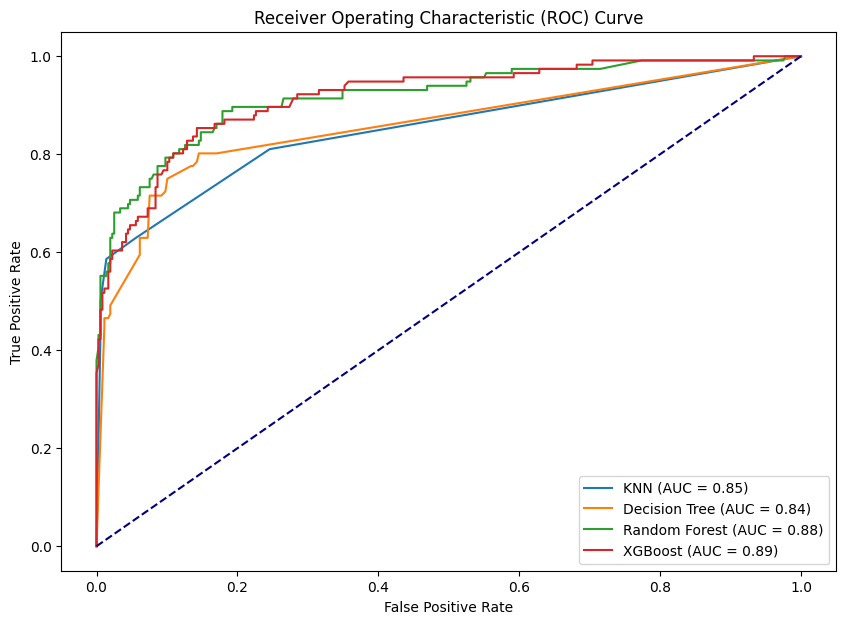

In [4]:
# RUN 1
# The features and target variable are extracted from the DF and stored in X and y, respectively.
X = df[['days_since_modified', 'AS_count', 'cone', 'relationship', 'only_asn', 'keyword_present']]
y = df['class']

# Define the transformer
transformer = PowerTransformer()

# Define the classifiers that would be used
classifiers = {
    'KNN': KNeighborsClassifier,
    'Decision Tree': DecisionTreeClassifier,
    'Random Forest': RandomForestClassifier,
    'XGBoost': XGBClassifier
}

# Define the hyperparameter grids for each classifier
param_grids = {
    'KNN': {
        "n_neighbors": [3, 5, 7, 9, 11, 13],
        "weights": ['uniform', 'distance'],
        "metric": ['euclidean', 'manhattan']
    },
    'Decision Tree': {
        "max_depth": [5, 10, 15],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "criterion": ["gini", "entropy"]
    },
    'Random Forest': {
        "n_estimators": [100, 200, 300],
        "max_depth": [5, 10, 15],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "bootstrap": [True, False],
        "criterion": ["gini", "entropy"]
    },
    'XGBoost': {
        "n_estimators": [250, 260, 270, 300, 400],
        "max_depth": [5, 10, 15],
        "learning_rate": [0.01, 0.1, 0.2],
        "subsample": [0.5, 0.7, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0]
    }
}

# Define the outer cross-validation loop
outer_cv = StratifiedKFold(n_splits=5)

# Here ROC curve data will be stored for plotting
roc_curve_data = {}

# Iterate through the classifiers
# For each classifier, the code goes through the outer cross-validation loop and evaluates the 
# model's performance on each outer fold using various metrics such as accuracy, precision, recall, F1-score, and ROC AUC.
for classifier_name, Classifier in classifiers.items():
    param_grid = param_grids[classifier_name]
    
    # Create lists to hold the scores for each outer fold
    outer_accuracies = []
    outer_precisions = []
    outer_recalls = []
    outer_f1_scores = []
    outer_roc_aucs = []

    # Outer cross-validation loop
    for train_idx, test_idx in outer_cv.split(X, y):

        # Split the data into training and testing sets
        X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Transform only 'days_since_modified', 'AS_count' and 'cone' features using specified transformer
        X_train[['days_since_modified', 'AS_count', 'cone']] = transformer.fit_transform(X_train[['days_since_modified', 'AS_count', 'cone']])
        X_test[['days_since_modified', 'AS_count', 'cone']] = transformer.transform(X_test[['days_since_modified', 'AS_count', 'cone']])

        # Define the inner cross-validation, where StratifiedKFold is used
        inner_cv = StratifiedKFold(n_splits=5)

        # Grid search (GridSearchCV) with inner cross-validation is performed to find the best hyperparameters for each classifier.
        # Here all cores will be used 
        grid = GridSearchCV(
            Classifier() if classifier_name != 'XGBoost' else Classifier(eval_metric='logloss'),
            param_grid, cv=inner_cv, scoring='recall', verbose=0, n_jobs=-1)

        # Fit the grid search object to the training data
        grid.fit(X_train, y_train)

        # Get the best parameters during inner cross-validation
        cv_best_parameters = grid.best_params_

        # Train the model using the best parameters
        best_model = Classifier(**cv_best_parameters) if classifier_name != 'XGBoost' else Classifier(eval_metric='logloss', **cv_best_parameters)
        best_model.fit(X_train, y_train)

        # Evaluate on the test set
        y_pred = best_model.predict(X_test)

        # Calculate performance metrics for the best model on the test set
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Calculate ROC AUC for the best model on the test set
        y_prob = best_model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob)

        # Store the scores for this outer fold
        outer_accuracies.append(accuracy)
        outer_precisions.append(precision)
        outer_recalls.append(recall)
        outer_f1_scores.append(f1)
        outer_roc_aucs.append(roc_auc)

    # Print the mean and standard deviation of the outer scores
    print(f"Results for {classifier_name}:")
    print("Best Parameters:", cv_best_parameters)
    print("Mean accuracy:", np.mean(outer_accuracies))
    print("Mean precision:", np.mean(outer_precisions))
    print("Mean recall:", np.mean(outer_recalls))
    print("Mean F1-score:", np.mean(outer_f1_scores))
    print("Mean ROC AUC:", np.mean(outer_roc_aucs))
    
    
    # Store the mean ROC AUC for plotting
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_curve_data[classifier_name] = (fpr, tpr, np.mean(outer_roc_aucs))
    
# Plot the ROC curves
plt.figure(figsize=(10, 7))
for classifier_name, (fpr, tpr, roc_auc) in roc_curve_data.items():
    plt.plot(fpr, tpr, label=f'{classifier_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Results for KNN:
Best Parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
Mean accuracy: 0.8662447257383967
Mean precision: 0.8714232150290263
Mean recall: 0.8662447257383967
Mean F1-score: 0.8569879183926155
Mean ROC AUC: 0.8377310026340995
Results for Decision Tree:
Best Parameters: {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 10}
Mean accuracy: 0.8603375527426159
Mean precision: 0.8572788012804624
Mean recall: 0.8603375527426159
Mean F1-score: 0.8571447901163569
Mean ROC AUC: 0.8335760658947848
Results for Random Forest:
Best Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Mean accuracy: 0.8776371308016877
Mean precision: 0.8819876008175956
Mean recall: 0.8776371308016877
Mean F1-score: 0.8689294873963741
Mean ROC AUC: 0.8822227389440929
Results for XGBoost:
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth

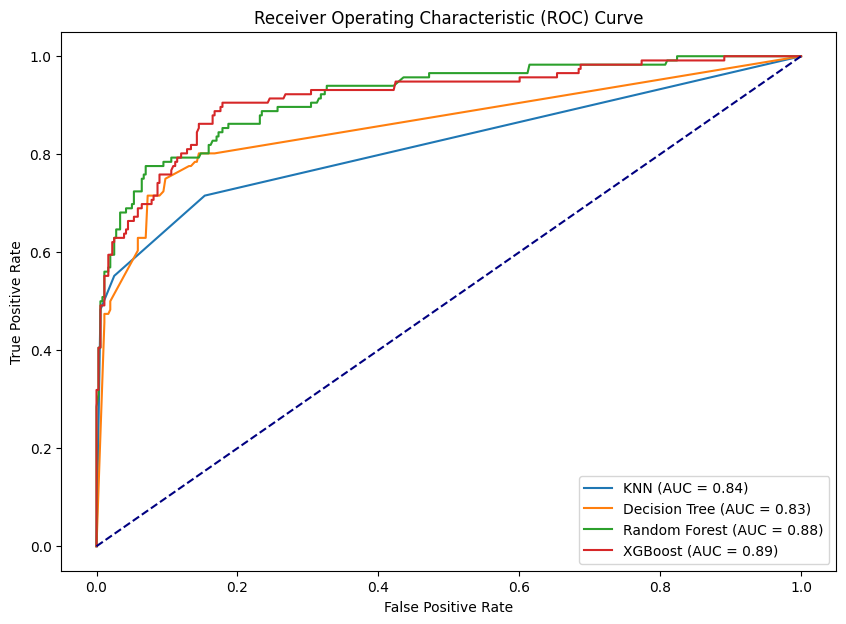

In [5]:
# RUN2
# This section will have less comments, since most of the things has been already described in RUN1
# The features and target variable are extracted from the DF and stored in X and y, respectively.
X = df[['days_since_modified', 'AS_count', 'cone', 'relationship', 'only_asn', 'keyword_present']]
y = df['class']

# Define the classifiers that would be used

classifiers = {
    'KNN': KNeighborsClassifier,
    'Decision Tree': DecisionTreeClassifier,
    'Random Forest': RandomForestClassifier,
    'XGBoost': XGBClassifier
}

# Define the hyperparameter grids for each classifier

param_grids = {
    'KNN': {
        "n_neighbors": [3, 5, 7, 9, 11, 13],
        "weights": ['uniform', 'distance'],
        "metric": ['euclidean', 'manhattan']
    },
    'Decision Tree': {
        "max_depth": [5, 10, 15],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "criterion": ["gini", "entropy"]
    },
    'Random Forest': {
        "n_estimators": [100, 200, 300],
        "max_depth": [5, 10, 15],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "bootstrap": [True, False],
        "criterion": ["gini", "entropy"]
    },
    'XGBoost': {
        "n_estimators": [250, 260, 270, 300, 400],
        "max_depth": [5, 10, 15],
        "learning_rate": [0.01, 0.1, 0.2],
        "subsample": [0.5, 0.7, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0]
    }
}

# Define the outer cross-validation loop
outer_cv = StratifiedKFold(n_splits=5)

# Here ROC curve data will be stored for plotting
roc_curve_data = {}

# Iterate through the classifiers
# For each classifier, the code goes through the outer cross-validation loop and evaluates the 
# model's performance on each outer fold using various metrics such as accuracy, precision, recall, F1-score, and ROC AUC.

for classifier_name, Classifier in classifiers.items():
    param_grid = param_grids[classifier_name]

# Create lists to hold the scores for each outer fold
    outer_accuracies = []
    outer_precisions = []
    outer_recalls = []
    outer_f1_scores = []
    outer_roc_aucs = []

    # Outer cross-validation loop
    for train_idx, test_idx in outer_cv.split(X, y):

        # Split the data into training and testing sets
        X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Apply log transform on only 'days_since_modified', 'AS_count' and 'cone' features
        X_train[['days_since_modified', 'AS_count', 'cone']] = np.log1p(X_train[['days_since_modified', 'AS_count', 'cone']])
        X_test[['days_since_modified', 'AS_count', 'cone']] = np.log1p(X_test[['days_since_modified', 'AS_count', 'cone']])

        # Define the inner cross-validation, where StratifiedKFold is used
        inner_cv = StratifiedKFold(n_splits=5)

        # Grid search (GridSearchCV) with inner cross-validation is performed to find the best hyperparameters for each classifier.
        # Here all cores will be used 

        grid = GridSearchCV(
            Classifier() if classifier_name != 'XGBoost' else Classifier(eval_metric='logloss'),
            param_grid, cv=inner_cv, scoring='recall', verbose=0, n_jobs=-1)

        # Fit the grid search object to the training data
        grid.fit(X_train, y_train)

        # Get the best parameters during inner cross-validation
        cv_best_parameters = grid.best_params_

        # Train the model using the best parameters
        best_model = Classifier(**cv_best_parameters) if classifier_name != 'XGBoost' else Classifier(eval_metric='logloss', **cv_best_parameters)
        best_model.fit(X_train, y_train)

        # Evaluate on the test set
        y_pred = best_model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        y_prob = best_model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob)

        outer_accuracies.append(accuracy)
        outer_precisions.append(precision)
        outer_recalls.append(recall)
        outer_f1_scores.append(f1)
        outer_roc_aucs.append(roc_auc)

    print(f"Results for {classifier_name}:")
    print("Best Parameters:", cv_best_parameters) 
    print("Mean accuracy:", np.mean(outer_accuracies))
    print("Mean precision:", np.mean(outer_precisions))
    print("Mean recall:", np.mean(outer_recalls))
    print("Mean F1-score:", np.mean(outer_f1_scores))
    print("Mean ROC AUC:", np.mean(outer_roc_aucs))

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_curve_data[classifier_name] = (fpr, tpr, np.mean(outer_roc_aucs))

plt.figure(figsize=(10, 7))
for classifier_name, (fpr, tpr, roc_auc) in roc_curve_data.items():
    plt.plot(fpr, tpr, label=f'{classifier_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Results for KNN:
Best Parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
Mean accuracy: 0.8725738396624472
Mean precision: 0.8748443652338332
Mean recall: 0.8725738396624472
Mean F1-score: 0.8618620000695312
Mean ROC AUC: 0.8453868088597739
Results for Decision Tree:
Best Parameters: {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 10}
Mean accuracy: 0.8514767932489452
Mean precision: 0.8539669242926827
Mean recall: 0.8514767932489452
Mean F1-score: 0.8494528257786047
Mean ROC AUC: 0.8064861720919003
Results for Random Forest:
Best Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Mean accuracy: 0.8776371308016879
Mean precision: 0.882052121377536
Mean recall: 0.8776371308016879
Mean F1-score: 0.8689521477555479
Mean ROC AUC: 0.8831626682690462
Results for XGBoost:
Best Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth'

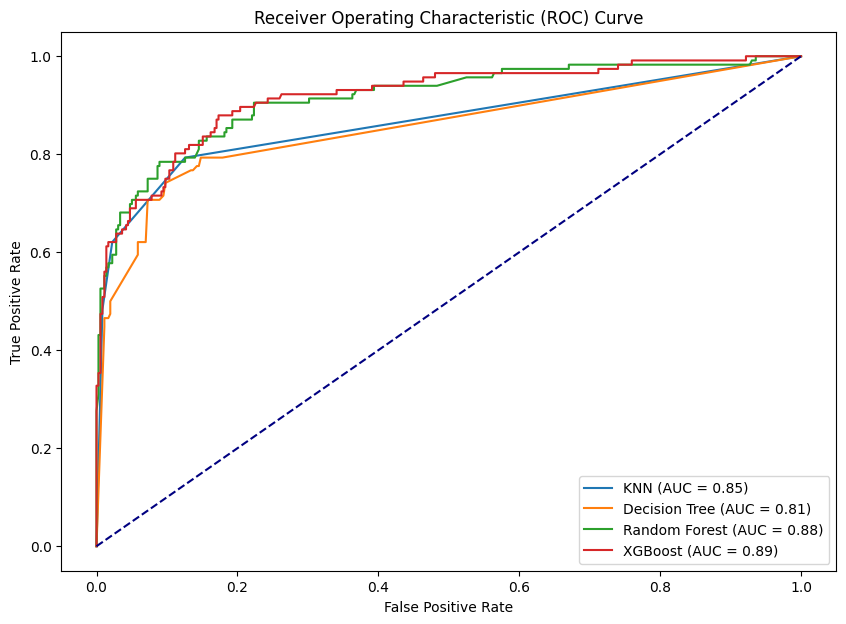

In [6]:
# RUN3
# This section will have less comments, since most of the things has been already described in RUN1
# The features and target variable are extracted from the DF and stored in X and y, respectively.
X = df[['days_since_modified', 'AS_count', 'cone', 'relationship', 'only_asn', 'keyword_present']]
y = df['class']

# Define the transformer
transformer = QuantileTransformer()

# Define the hyperparameter grids for each classifier
classifiers = {
    'KNN': KNeighborsClassifier,
    'Decision Tree': DecisionTreeClassifier,
    'Random Forest': RandomForestClassifier,
    'XGBoost': XGBClassifier
}

# Define the hyperparameter grids for each classifier
param_grids = {
    'KNN': {
        "n_neighbors": [3, 5, 7, 9, 11, 13],
        "weights": ['uniform', 'distance'],
        "metric": ['euclidean', 'manhattan']
    },
    'Decision Tree': {
        "max_depth": [5, 10, 15],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "criterion": ["gini", "entropy"]
    },
    'Random Forest': {
        "n_estimators": [100, 200, 300],
        "max_depth": [5, 10, 15],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "bootstrap": [True, False],
        "criterion": ["gini", "entropy"]
    },
    'XGBoost': {
        "n_estimators": [250, 260, 270, 300, 400],
        "max_depth": [5, 10, 15],
        "learning_rate": [0.01, 0.1, 0.2],
        "subsample": [0.5, 0.7, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0]
    }
}


# Define the outer cross-validation loop
outer_cv = StratifiedKFold(n_splits=5)

# To store ROC curve data for plotting
roc_curve_data = {}

# Iterate through the classifiers
for classifier_name, Classifier in classifiers.items():
    param_grid = param_grids[classifier_name]
    
    # Create lists to hold the scores for each outer fold
    outer_accuracies = []
    outer_precisions = []
    outer_recalls = []
    outer_f1_scores = []
    outer_roc_aucs = []

    # Outer cross-validation loop
    for train_idx, test_idx in outer_cv.split(X, y):

        # Split the data into training and testing sets
        X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Transform only specific features
        X_train[['days_since_modified', 'AS_count', 'cone']] = transformer.fit_transform(X_train[['days_since_modified', 'AS_count', 'cone']])
        X_test[['days_since_modified', 'AS_count', 'cone']] = transformer.transform(X_test[['days_since_modified', 'AS_count', 'cone']])

        # Define the inner cross-validation
        inner_cv = StratifiedKFold(n_splits=5)

        # Perform grid search with inner cross-validation, using all cores
        grid = GridSearchCV(
            Classifier() if classifier_name != 'XGBoost' else Classifier(eval_metric='logloss'),
            param_grid, cv=inner_cv, scoring='recall', verbose=0, n_jobs=-1)

        # Fit the grid search object to the training data
        grid.fit(X_train, y_train)

        # Get the best parameters during inner cross-validation
        cv_best_parameters = grid.best_params_

        # Train the model using the best parameters
        best_model = Classifier(**cv_best_parameters) if classifier_name != 'XGBoost' else Classifier(eval_metric='logloss', **cv_best_parameters)
        best_model.fit(X_train, y_train)

        # Evaluate on the test set
        y_pred = best_model.predict(X_test)

        # Calculate performance metrics for the best model on the test set
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Calculate ROC AUC for the best model on the test set
        y_prob = best_model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob)

        # Store the scores for this outer fold
        outer_accuracies.append(accuracy)
        outer_precisions.append(precision)
        outer_recalls.append(recall)
        outer_f1_scores.append(f1)
        outer_roc_aucs.append(roc_auc)

    # Print the mean and standard deviation of the outer scores
    print(f"Results for {classifier_name}:")
    print("Best Parameters:", cv_best_parameters)  
    print("Mean accuracy:", np.mean(outer_accuracies))
    print("Mean precision:", np.mean(outer_precisions))
    print("Mean recall:", np.mean(outer_recalls))
    print("Mean F1-score:", np.mean(outer_f1_scores))
    print("Mean ROC AUC:", np.mean(outer_roc_aucs))
    
    # Store the mean ROC AUC for plotting
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_curve_data[classifier_name] = (fpr, tpr, np.mean(outer_roc_aucs))

# Plot the ROC curves
plt.figure(figsize=(10, 7))
for classifier_name, (fpr, tpr, roc_auc) in roc_curve_data.items():
    plt.plot(fpr, tpr, label=f'{classifier_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Results for KNN:
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Mean accuracy: 0.7565400843881857
Mean precision: 0.7483436118445834
Mean recall: 0.7565400843881857
Mean F1-score: 0.747532455989621
Mean ROC AUC: 0.6970958460328822
Results for Decision Tree:
Best Parameters: {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mean accuracy: 0.860759493670886
Mean precision: 0.8577263249356017
Mean recall: 0.860759493670886
Mean F1-score: 0.8562129817906339
Mean ROC AUC: 0.812601237720879
Results for Random Forest:
Best Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Mean accuracy: 0.8767932489451477
Mean precision: 0.8803368402448248
Mean recall: 0.8767932489451477
Mean F1-score: 0.8679860879152239
Mean ROC AUC: 0.8778161840322894
Results for XGBoost:
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5

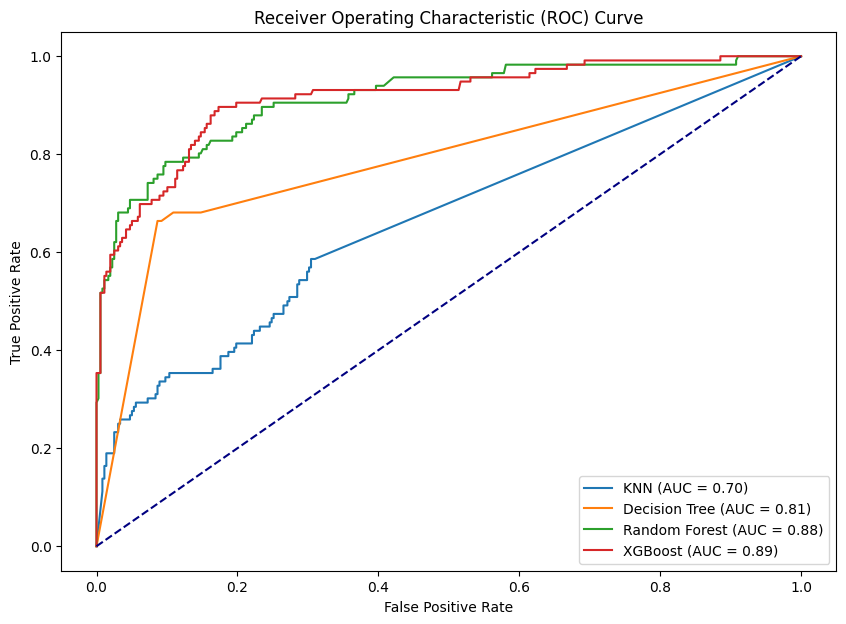

In [4]:
# RUN4
# During this run, no scaler will be used, to compare results
# This section will have less comments, since most of the things has been already described in RUN1
# The features and target variable are extracted from the DF and stored in X and y, respectively.
X = df[['days_since_modified', 'AS_count', 'cone', 'relationship', 'only_asn', 'keyword_present']]
y = df['class']

# Define the classifiers to try
classifiers = {
    'KNN': KNeighborsClassifier,
    'Decision Tree': DecisionTreeClassifier,
    'Random Forest': RandomForestClassifier,
    'XGBoost': XGBClassifier
}

# Define the hyperparameter grids for each classifier
param_grids = {
    'KNN': {
        "n_neighbors": [3, 5, 7, 9, 11, 13],
        "weights": ['uniform', 'distance'],
        "metric": ['euclidean', 'manhattan']
    },
    'Decision Tree': {
        "max_depth": [5, 10, 15],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "criterion": ["gini", "entropy"]
    },
    'Random Forest': {
        "n_estimators": [100, 200, 300],
        "max_depth": [5, 10, 15],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "bootstrap": [True, False],
        "criterion": ["gini", "entropy"]
    },
    'XGBoost': {
        "n_estimators": [250, 260, 270, 300, 400],
        "max_depth": [5, 10, 15],
        "learning_rate": [0.01, 0.1, 0.2],
        "subsample": [0.5, 0.7, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0]
    }
}

# Define the outer cross-validation strategy
outer_cv = StratifiedKFold(n_splits=5)

# To store ROC curve data for plotting
roc_curve_data = {}

# Iterate through the classifiers
for classifier_name, Classifier in classifiers.items():
    param_grid = param_grids[classifier_name]
    
    # Create lists to hold the scores for each outer fold
    outer_accuracies = []
    outer_precisions = []
    outer_recalls = []
    outer_f1_scores = []
    outer_roc_aucs = []

    # Outer cross-validation loop
    for train_idx, test_idx in outer_cv.split(X, y):

        # Split the data into training and testing sets, no scaling is applied
        X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Define the inner cross-validation
        inner_cv = StratifiedKFold(n_splits=5)

        # Perform grid search with inner cross-validation, using all cores
        grid = GridSearchCV(
            Classifier() if classifier_name != 'XGBoost' else Classifier(eval_metric='logloss'),
            param_grid, cv=inner_cv, scoring='recall', verbose=0, n_jobs=-1)

        # Fit the grid search object to the training data
        grid.fit(X_train, y_train)

        # Get the best parameters during inner cross-validation
        cv_best_parameters = grid.best_params_

        # Train the model using the best parameters
        best_model = Classifier(**cv_best_parameters) if classifier_name != 'XGBoost' else Classifier(eval_metric='logloss', **cv_best_parameters)
        best_model.fit(X_train, y_train)

        # Evaluate on the test set
        y_pred = best_model.predict(X_test)

        # Calculate performance metrics for the best model on the test set
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Calculate ROC AUC for the best model on the test set
        y_prob = best_model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob)

        # Store the scores for this outer fold
        outer_accuracies.append(accuracy)
        outer_precisions.append(precision)
        outer_recalls.append(recall)
        outer_f1_scores.append(f1)
        outer_roc_aucs.append(roc_auc)

    # Print the mean and standard deviation of the outer scores
    print(f"Results for {classifier_name}:")
    print("Best Parameters:", cv_best_parameters)  # Added line to print best parameters
    print("Mean accuracy:", np.mean(outer_accuracies))
    print("Mean precision:", np.mean(outer_precisions))
    print("Mean recall:", np.mean(outer_recalls))
    print("Mean F1-score:", np.mean(outer_f1_scores))
    print("Mean ROC AUC:", np.mean(outer_roc_aucs))
    
    # Store the mean ROC AUC for plotting
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_curve_data[classifier_name] = (fpr, tpr, np.mean(outer_roc_aucs))

# Plot the ROC curves
plt.figure(figsize=(10, 7))
for classifier_name, (fpr, tpr, roc_auc) in roc_curve_data.items():
    plt.plot(fpr, tpr, label=f'{classifier_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Results for KNN:
Best Parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Mean accuracy: 0.8160337552742616
Mean precision: 0.8374881684486951
Mean recall: 0.8160337552742616
Mean F1-score: 0.8194708098319969
Mean ROC AUC: 0.855143913897613
Results for Decision Tree:
Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5}
Mean accuracy: 0.8506329113924052
Mean precision: 0.8617639076080265
Mean recall: 0.8506329113924052
Mean F1-score: 0.8534467635054573
Mean ROC AUC: 0.8526778634227494
Results for Random Forest:
Best Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Mean accuracy: 0.8565400843881855
Mean precision: 0.8707562958930242
Mean recall: 0.8565400843881855
Mean F1-score: 0.859189118688772
Mean ROC AUC: 0.8887588118376037
Results for XGBoost:
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth'

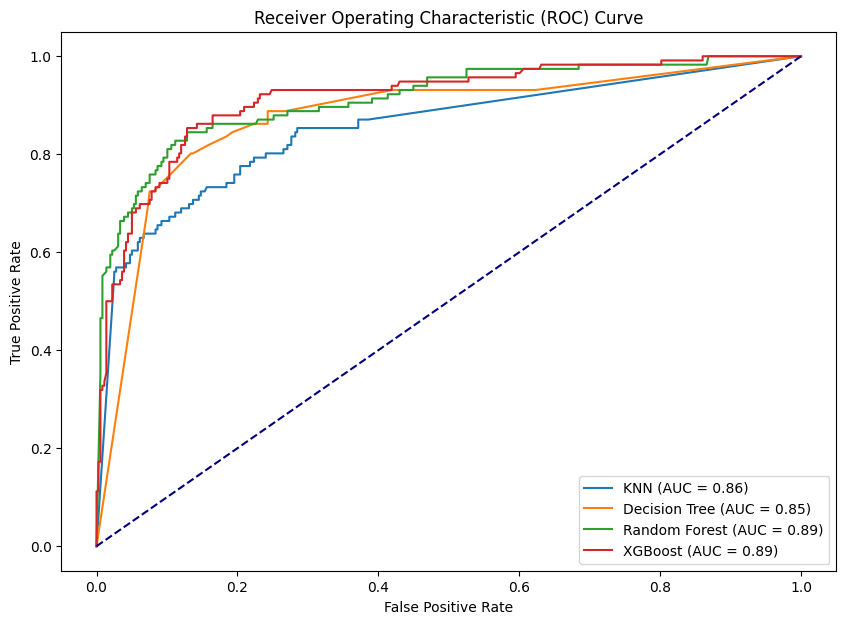

In [5]:
# RUN5
# During this run UNDERSAMPLING method will be applied
# This section will have less comments, since it has already be described in RUN1
# The features and target variable are extracted from the DF and stored in X and y, respectively.
X = df[['days_since_modified', 'AS_count', 'cone', 'relationship', 'only_asn', 'keyword_present']]
y = df['class']

# Define the scaler
scaler = PowerTransformer()

# Define the classifiers to try
classifiers = {
    'KNN': KNeighborsClassifier,
    'Decision Tree': DecisionTreeClassifier,
    'Random Forest': RandomForestClassifier,
    'XGBoost': XGBClassifier
}

# Define the hyperparameter grids for each classifier
param_grids = {
    'KNN': {
        "n_neighbors": [3, 5, 7, 9, 11, 13],
        "weights": ['uniform', 'distance'],
        "metric": ['euclidean', 'manhattan']
    },
    'Decision Tree': {
        "max_depth": [5, 10, 15],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "criterion": ["gini", "entropy"]
    },
    'Random Forest': {
        "n_estimators": [100, 200, 300],
        "max_depth": [5, 10, 15],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "bootstrap": [True, False],
        "criterion": ["gini", "entropy"]
    },
    'XGBoost': {
        "n_estimators": [250, 260, 270, 300, 400],
        "max_depth": [5, 10, 15],
        "learning_rate": [0.01, 0.1, 0.2],
        "subsample": [0.5, 0.7, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0]
    }
}


# Define the outer cross-validation strategy
outer_cv = StratifiedKFold(n_splits=5)

# To store ROC curve data for plotting
roc_curve_data = {}

# Iterate through the classifiers
for classifier_name, Classifier in classifiers.items():
    param_grid = param_grids[classifier_name]
    
    # Create lists to hold the scores for each outer fold
    outer_accuracies = []
    outer_precisions = []
    outer_recalls = []
    outer_f1_scores = []
    outer_roc_aucs = []

    # Outer cross-validation loop
    for train_idx, test_idx in outer_cv.split(X, y):

        # Split the data into training and testing sets
        X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Scale only specific features
        X_train[['days_since_modified', 'AS_count', 'cone']] = scaler.fit_transform(X_train[['days_since_modified', 'AS_count', 'cone']])
        X_test[['days_since_modified', 'AS_count', 'cone']] = scaler.transform(X_test[['days_since_modified', 'AS_count', 'cone']])

        # Define the inner cross-validation
        inner_cv = StratifiedKFold(n_splits=5)

        # Define the undersampler
        undersampler = RandomUnderSampler()

        # Define the pipeline with undersampling and the classifier
        pipeline = Pipeline([
            # The first step is the undersampler, which reduces the number of instances in the majority class(es).
            ('undersample', undersampler),
            #The second step is the classifier for the given classifier name.
            ('classifier', Classifier() if classifier_name != 'XGBoost' else Classifier(eval_metric='logloss'))
        ])

        # Update the parameter grid to work with the pipeline
        param_grid_pipeline = {f"classifier__{key}": value for key, value in param_grid.items()}

        # Perform grid search with inner cross-validation, using all cores
        grid = GridSearchCV(
            pipeline,
            param_grid_pipeline, cv=inner_cv, scoring='recall', verbose=0, n_jobs=-1)

        # Fit the grid search object to the training data
        grid.fit(X_train, y_train)

        # Get the best parameters during inner cross-validation
        cv_best_parameters = {key.replace("classifier__", ""): value for key, value in grid.best_params_.items()}

        # Train the model using the best parameters
        best_model = Pipeline([
            ('undersample', undersampler),
            ('classifier', Classifier(**cv_best_parameters) if classifier_name != 'XGBoost' else Classifier(eval_metric='logloss', **cv_best_parameters))
        ])
        best_model.fit(X_train, y_train)

        # Evaluate on the test set
        y_pred = best_model.predict(X_test)
        
        # Calculate performance metrics for the best model on the test set
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Calculate ROC AUC for the best model on the test set
        y_prob = best_model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob)

        # Store the scores for this outer fold
        outer_accuracies.append(accuracy)
        outer_precisions.append(precision)
        outer_recalls.append(recall)
        outer_f1_scores.append(f1)
        outer_roc_aucs.append(roc_auc)

    # Print the mean and standard deviation of the outer scores
    print(f"Results for {classifier_name}:")
    print("Best Parameters:", cv_best_parameters)  # Added line to print best parameters
    print("Mean accuracy:", np.mean(outer_accuracies))
    print("Mean precision:", np.mean(outer_precisions))
    print("Mean recall:", np.mean(outer_recalls))
    print("Mean F1-score:", np.mean(outer_f1_scores))
    print("Mean ROC AUC:", np.mean(outer_roc_aucs))
    
    # Store the mean ROC AUC for plotting
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_curve_data[classifier_name] = (fpr, tpr, np.mean(outer_roc_aucs))

# Plot the ROC curves
plt.figure(figsize=(10, 7))
for classifier_name, (fpr, tpr, roc_auc) in roc_curve_data.items():
    plt.plot(fpr, tpr, label=f'{classifier_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Results for KNN:
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 13, 'weights': 'uniform'}
Mean accuracy: 0.8367088607594937
Mean precision: 0.84972430743971
Mean recall: 0.8367088607594937
Mean F1-score: 0.8370265119600082
Mean ROC AUC: 0.875913712799379
Results for Decision Tree:
Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mean accuracy: 0.8561181434599157
Mean precision: 0.8741665407353529
Mean recall: 0.8561181434599157
Mean F1-score: 0.8576133216396269
Mean ROC AUC: 0.8739600140095838
Results for Random Forest:
Best Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Mean accuracy: 0.8481012658227849
Mean precision: 0.8647044645641317
Mean recall: 0.8481012658227849
Mean F1-score: 0.8503568044829966
Mean ROC AUC: 0.8867989818134614
Results for XGBoost:
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_de

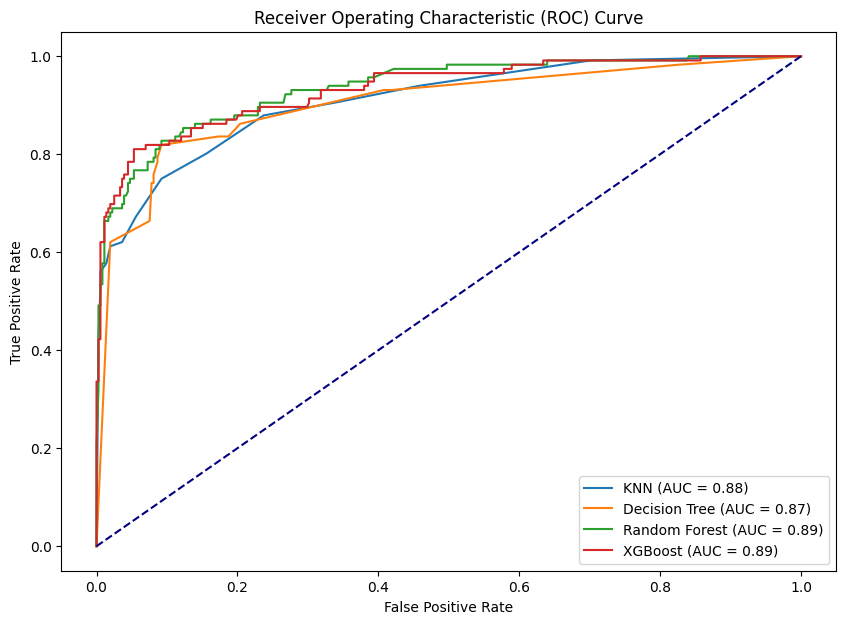

In [6]:
# RUN6
# This section will have less comments, since it has already be described in RUN1
# The features and target variable are extracted from the DF and stored in X and y, respectively.
X = df[['days_since_modified', 'AS_count', 'cone', 'relationship', 'only_asn', 'keyword_present']]
y = df['class']

# Define the scaler
scaler = QuantileTransformer()

# Define the classifiers to try
classifiers = {
    'KNN': KNeighborsClassifier,
    'Decision Tree': DecisionTreeClassifier,
    'Random Forest': RandomForestClassifier,
    'XGBoost': XGBClassifier
}

# Define the hyperparameter grids for each classifier
param_grids = {
    'KNN': {
        "n_neighbors": [3, 5, 7, 9, 11, 13],
        "weights": ['uniform', 'distance'],
        "metric": ['euclidean', 'manhattan']
    },
    'Decision Tree': {
        "max_depth": [5, 10, 15],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "criterion": ["gini", "entropy"]
    },
    'Random Forest': {
        "n_estimators": [100, 200, 300],
        "max_depth": [5, 10, 15],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "bootstrap": [True, False],
        "criterion": ["gini", "entropy"]
    },
    'XGBoost': {
        "n_estimators": [250, 260, 270, 300, 400],
        "max_depth": [5, 10, 15],
        "learning_rate": [0.01, 0.1, 0.2],
        "subsample": [0.5, 0.7, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0]
    }
}



# Define the outer cross-validation strategy
outer_cv = StratifiedKFold(n_splits=5)

# To store ROC curve data for plotting
roc_curve_data = {}

# Iterate through the classifiers
for classifier_name, Classifier in classifiers.items():
    param_grid = param_grids[classifier_name]
    
    # Create lists to hold the scores for each outer fold
    outer_accuracies = []
    outer_precisions = []
    outer_recalls = []
    outer_f1_scores = []
    outer_roc_aucs = []

    # Outer cross-validation loop
    for train_idx, test_idx in outer_cv.split(X, y):

        # Split the data into training and testing sets
        X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Scale only specific features
        X_train[['days_since_modified', 'AS_count', 'cone']] = scaler.fit_transform(X_train[['days_since_modified', 'AS_count', 'cone']])
        X_test[['days_since_modified', 'AS_count', 'cone']] = scaler.transform(X_test[['days_since_modified', 'AS_count', 'cone']])

        # Define the inner cross-validation
        inner_cv = StratifiedKFold(n_splits=5)

        # Define the undersampler
        undersampler = RandomUnderSampler()

        # Define the pipeline with undersampling and the classifier
        pipeline = Pipeline([
            ('undersample', undersampler),
            ('classifier', Classifier() if classifier_name != 'XGBoost' else Classifier(eval_metric='logloss'))
        ])

        # Update the parameter grid to work with the pipeline
        param_grid_pipeline = {f"classifier__{key}": value for key, value in param_grid.items()}

        # Perform grid search with inner cross-validation, using all cores
        grid = GridSearchCV(
            pipeline,
            param_grid_pipeline, cv=inner_cv, scoring='recall', verbose=0, n_jobs=-1)

        # Fit the grid search object to the training data
        grid.fit(X_train, y_train)

        # Get the best parameters during inner cross-validation
        cv_best_parameters = {key.replace("classifier__", ""): value for key, value in grid.best_params_.items()}

        # Train the model using the best parameters
        best_model = Pipeline([
            ('undersample', undersampler),
            ('classifier', Classifier(**cv_best_parameters) if classifier_name != 'XGBoost' else Classifier(eval_metric='logloss', **cv_best_parameters))
        ])
        best_model.fit(X_train, y_train)

        # Evaluate on the test set
        y_pred = best_model.predict(X_test)
        
        # Calculate performance metrics for the best model on the test set
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Calculate ROC AUC for the best model on the test set
        y_prob = best_model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob)

        # Store the scores for this outer fold
        outer_accuracies.append(accuracy)
        outer_precisions.append(precision)
        outer_recalls.append(recall)
        outer_f1_scores.append(f1)
        outer_roc_aucs.append(roc_auc)

    # Print the mean and standard deviation of the outer scores
    print(f"Results for {classifier_name}:")
    print("Best Parameters:", cv_best_parameters)  # Added line to print best parameters
    print("Mean accuracy:", np.mean(outer_accuracies))
    print("Mean precision:", np.mean(outer_precisions))
    print("Mean recall:", np.mean(outer_recalls))
    print("Mean F1-score:", np.mean(outer_f1_scores))
    print("Mean ROC AUC:", np.mean(outer_roc_aucs))
    
    # Store the mean ROC AUC for plotting
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_curve_data[classifier_name] = (fpr, tpr, np.mean(outer_roc_aucs))

# Plot the ROC curves
plt.figure(figsize=(10, 7))
for classifier_name, (fpr, tpr, roc_auc) in roc_curve_data.items():
    plt.plot(fpr, tpr, label=f'{classifier_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Results for KNN:
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'uniform'}
Mean accuracy: 0.8206751054852323
Mean precision: 0.8428799944220247
Mean recall: 0.8206751054852323
Mean F1-score: 0.824730022130249
Mean ROC AUC: 0.8529259038413132
Results for Decision Tree:
Best Parameters: {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mean accuracy: 0.8329113924050633
Mean precision: 0.8533040695944732
Mean recall: 0.8329113924050633
Mean F1-score: 0.8372689357930676
Mean ROC AUC: 0.8400488359327907
Results for Random Forest:
Best Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Mean accuracy: 0.8531645569620254
Mean precision: 0.8675146256986667
Mean recall: 0.8531645569620254
Mean F1-score: 0.855831474372768
Mean ROC AUC: 0.8879292586709557
Results for XGBoost:
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth':

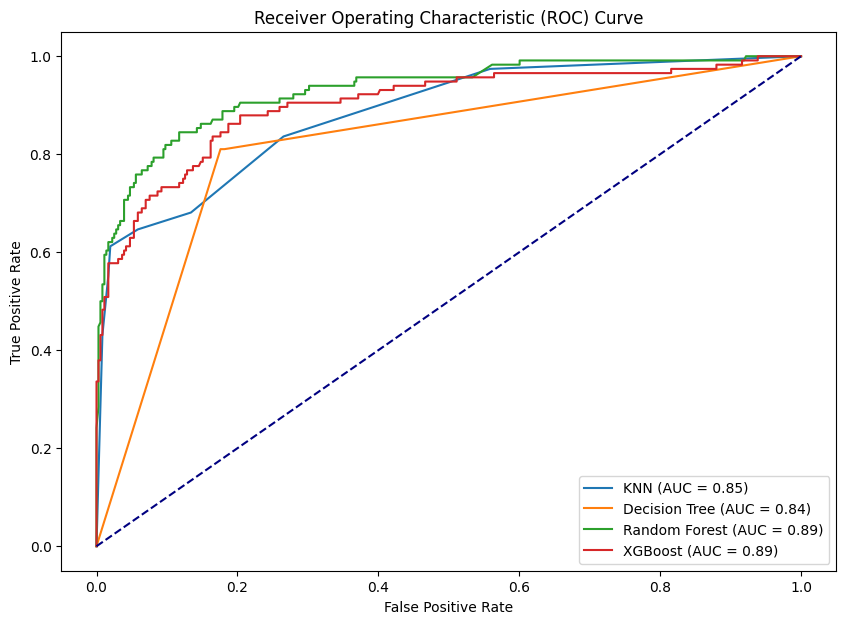

In [7]:
# RUN7
# This section will have less comments, since it has already be described in RUN1
# The features and target variable are extracted from the DF and stored in X and y, respectively.
X = df[['days_since_modified', 'AS_count', 'cone', 'relationship', 'only_asn', 'keyword_present']]
y = df['class']

# Define the classifiers to try
classifiers = {
    'KNN': KNeighborsClassifier,
    'Decision Tree': DecisionTreeClassifier,
    'Random Forest': RandomForestClassifier,
    'XGBoost': XGBClassifier
}

# Define the hyperparameter grids for each classifier
param_grids = {
    'KNN': {
        "n_neighbors": [3, 5, 7, 9, 11, 13],
        "weights": ['uniform', 'distance'],
        "metric": ['euclidean', 'manhattan']
    },
    'Decision Tree': {
        "max_depth": [5, 10, 15],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "criterion": ["gini", "entropy"]
    },
    'Random Forest': {
        "n_estimators": [100, 200, 300],
        "max_depth": [5, 10, 15],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "bootstrap": [True, False],
        "criterion": ["gini", "entropy"]
    },
    'XGBoost': {
        "n_estimators": [250, 260, 270, 300, 400],
        "max_depth": [5, 10, 15],
        "learning_rate": [0.01, 0.1, 0.2],
        "subsample": [0.5, 0.7, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0]
    }
}


# Define the outer cross-validation strategy
outer_cv = StratifiedKFold(n_splits=5)

# To store ROC curve data for plotting
roc_curve_data = {}

# Iterate through the classifiers
for classifier_name, Classifier in classifiers.items():
    param_grid = param_grids[classifier_name]
    
    # Create lists to hold the scores for each outer fold
    outer_accuracies = []
    outer_precisions = []
    outer_recalls = []
    outer_f1_scores = []
    outer_roc_aucs = []

    # Outer cross-validation loop
    for train_idx, test_idx in outer_cv.split(X, y):

        # Split the data into training and testing sets
        X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Apply log transform on specific features
        X_train[['days_since_modified', 'AS_count', 'cone']] = np.log1p(X_train[['days_since_modified', 'AS_count', 'cone']])
        X_test[['days_since_modified', 'AS_count', 'cone']] = np.log1p(X_test[['days_since_modified', 'AS_count', 'cone']])

        # Define the inner cross-validation
        inner_cv = StratifiedKFold(n_splits=5)

        # Define the undersampler
        undersampler = RandomUnderSampler()

        # Define the pipeline with undersampling and the classifier
        pipeline = Pipeline([
            ('undersample', undersampler),
            ('classifier', Classifier() if classifier_name != 'XGBoost' else Classifier(eval_metric='logloss'))
        ])

        # Update the parameter grid to work with the pipeline
        param_grid_pipeline = {f"classifier__{key}": value for key, value in param_grid.items()}

        # Perform grid search with inner cross-validation, using all cores
        grid = GridSearchCV(
            pipeline,
            param_grid_pipeline, cv=inner_cv, scoring='recall', verbose=0, n_jobs=-1)

        # Fit the grid search object to the training data
        grid.fit(X_train, y_train)

        # Get the best parameters during inner cross-validation
        cv_best_parameters = {key.replace("classifier__", ""): value for key, value in grid.best_params_.items()}

        # Train the model using the best parameters
        best_model = Pipeline([
            ('undersample', undersampler),
            ('classifier', Classifier(**cv_best_parameters) if classifier_name != 'XGBoost' else Classifier(eval_metric='logloss', **cv_best_parameters))
        ])
        best_model.fit(X_train, y_train)

        # Evaluate on the test set
        y_pred = best_model.predict(X_test)
        
        # Calculate performance metrics for the best model on the test set
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Calculate ROC AUC for the best model on the test set
        y_prob = best_model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob)

        # Store the scores for this outer fold
        outer_accuracies.append(accuracy)
        outer_precisions.append(precision)
        outer_recalls.append(recall)
        outer_f1_scores.append(f1)
        outer_roc_aucs.append(roc_auc)

    # Print the mean and standard deviation of the outer scores
    print(f"Results for {classifier_name}:")
    print("Best Parameters:", cv_best_parameters)  # Added line to print best parameters
    print("Mean accuracy:", np.mean(outer_accuracies))
    print("Mean precision:", np.mean(outer_precisions))
    print("Mean recall:", np.mean(outer_recalls))
    print("Mean F1-score:", np.mean(outer_f1_scores))
    print("Mean ROC AUC:", np.mean(outer_roc_aucs))
    
    # Store the mean ROC AUC for plotting
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_curve_data[classifier_name] = (fpr, tpr, np.mean(outer_roc_aucs))

# Plot the ROC curves
plt.figure(figsize=(10, 7))
for classifier_name, (fpr, tpr, roc_auc) in roc_curve_data.items():
    plt.plot(fpr, tpr, label=f'{classifier_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Results for KNN:
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Mean accuracy: 0.6481012658227848
Mean precision: 0.7524820782052531
Mean recall: 0.6481012658227848
Mean F1-score: 0.6683918703416342
Mean ROC AUC: 0.7149984243067772
Results for Decision Tree:
Best Parameters: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 10}
Mean accuracy: 0.8240506329113924
Mean precision: 0.845105039464662
Mean recall: 0.8240506329113924
Mean F1-score: 0.8280579728590542
Mean ROC AUC: 0.8436888987696749
Results for Random Forest:
Best Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mean accuracy: 0.8426160337552743
Mean precision: 0.8621227829898748
Mean recall: 0.8426160337552743
Mean F1-score: 0.8463887342947611
Mean ROC AUC: 0.8810364116194341
Results for XGBoost:
Best Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_de

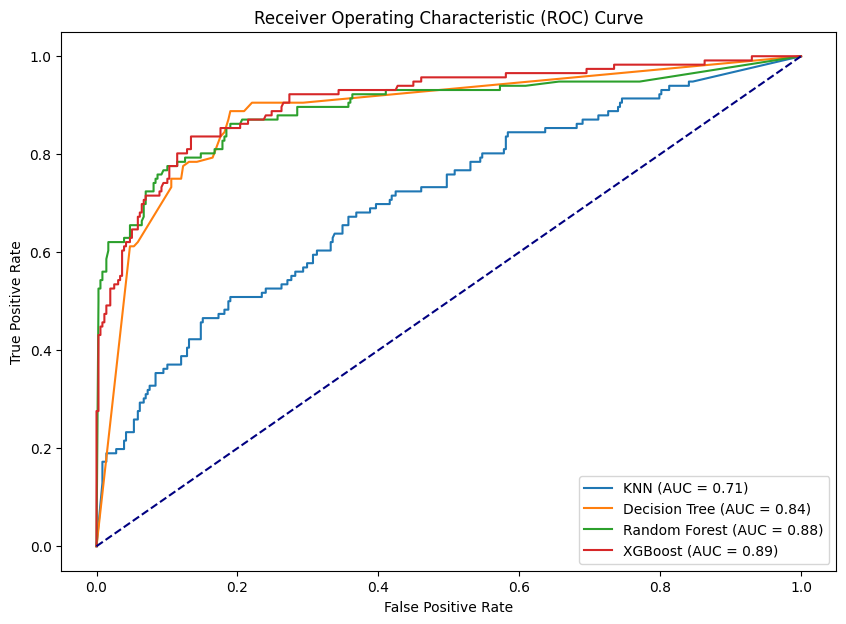

In [8]:
# RUN8
# This section will have less comments, since it has already be described in RUN1
# The features and target variable are extracted from the DF and stored in X and y, respectively.
X = df[['days_since_modified', 'AS_count', 'cone', 'relationship', 'only_asn', 'keyword_present']]
y = df['class']

# Define the classifiers to try
classifiers = {
    'KNN': KNeighborsClassifier,
    'Decision Tree': DecisionTreeClassifier,
    'Random Forest': RandomForestClassifier,
    'XGBoost': XGBClassifier
}

# Define the hyperparameter grids for each classifier
param_grids = {
    'KNN': {
        "n_neighbors": [3, 5, 7, 9, 11, 13],
        "weights": ['uniform', 'distance'],
        "metric": ['euclidean', 'manhattan']
    },
    'Decision Tree': {
        "max_depth": [5, 10, 15],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "criterion": ["gini", "entropy"]
    },
    'Random Forest': {
        "n_estimators": [100, 200, 300],
        "max_depth": [5, 10, 15],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "bootstrap": [True, False],
        "criterion": ["gini", "entropy"]
    },
    'XGBoost': {
        "n_estimators": [250, 260, 270, 300, 400],
        "max_depth": [5, 10, 15],
        "learning_rate": [0.01, 0.1, 0.2],
        "subsample": [0.5, 0.7, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0]
    }
}


# Define the outer cross-validation strategy
outer_cv = StratifiedKFold(n_splits=5)

# To store ROC curve data for plotting
roc_curve_data = {}

# Iterate through the classifiers
for classifier_name, Classifier in classifiers.items():
    param_grid = param_grids[classifier_name]
    
    # Create lists to hold the scores for each outer fold
    outer_accuracies = []
    outer_precisions = []
    outer_recalls = []
    outer_f1_scores = []
    outer_roc_aucs = []

    # Outer cross-validation loop
    for train_idx, test_idx in outer_cv.split(X, y):

        # Split the data into training and testing sets
        X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Define the inner cross-validation
        inner_cv = StratifiedKFold(n_splits=5)

        # Define the undersampler
        undersampler = RandomUnderSampler()

        # Define the pipeline with undersampling and the classifier
        pipeline = Pipeline([
            ('undersample', undersampler),
            ('classifier', Classifier() if classifier_name != 'XGBoost' else Classifier(eval_metric='logloss'))
        ])

        # Update the parameter grid to work with the pipeline
        param_grid_pipeline = {f"classifier__{key}": value for key, value in param_grid.items()}

        # Perform grid search with inner cross-validation, using all cores
        grid = GridSearchCV(
            pipeline,
            param_grid_pipeline, cv=inner_cv, scoring='recall', verbose=0, n_jobs=-1)

        # Fit the grid search object to the training data
        grid.fit(X_train, y_train)

        # Get the best parameters during inner cross-validation
        cv_best_parameters = {key.replace("classifier__", ""): value for key, value in grid.best_params_.items()}

        # Train the model using the best parameters
        best_model = Pipeline([
            ('undersample', undersampler),
            ('classifier', Classifier(**cv_best_parameters) if classifier_name != 'XGBoost' else Classifier(eval_metric='logloss', **cv_best_parameters))
        ])
        best_model.fit(X_train, y_train)

        # Evaluate on the test set
        y_pred = best_model.predict(X_test)
        
        # Calculate performance metrics for the best model on the test set
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Calculate ROC AUC for the best model on the test set
        y_prob = best_model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob)

        # Store the scores for this outer fold
        outer_accuracies.append(accuracy)
        outer_precisions.append(precision)
        outer_recalls.append(recall)
        outer_f1_scores.append(f1)
        outer_roc_aucs.append(roc_auc)

    # Print the mean and standard deviation of the outer scores
    print(f"Results for {classifier_name}:")
    print("Best Parameters:", cv_best_parameters)  # Added line to print best parameters
    print("Mean accuracy:", np.mean(outer_accuracies))
    print("Mean precision:", np.mean(outer_precisions))
    print("Mean recall:", np.mean(outer_recalls))
    print("Mean F1-score:", np.mean(outer_f1_scores))
    print("Mean ROC AUC:", np.mean(outer_roc_aucs))
    
    # Store the mean ROC AUC for plotting
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_curve_data[classifier_name] = (fpr, tpr, np.mean(outer_roc_aucs))

# Plot the ROC curves
plt.figure(figsize=(10, 7))
for classifier_name, (fpr, tpr, roc_auc) in roc_curve_data.items():
    plt.plot(fpr, tpr, label=f'{classifier_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [9]:
#oversampling smote

Results for KNN:
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 13, 'weights': 'uniform'}
Mean accuracy: 0.6645569620253163
Mean precision: 0.7477632572982305
Mean recall: 0.6645569620253163
Mean F1-score: 0.6820903765230459
Mean ROC AUC: 0.7156203663741338
Results for Decision Tree:
Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}
Mean accuracy: 0.8518987341772151
Mean precision: 0.8638197880741967
Mean recall: 0.8518987341772151
Mean F1-score: 0.8519525606068262
Mean ROC AUC: 0.8716289882244885
Results for Random Forest:
Best Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Mean accuracy: 0.8683544303797468
Mean precision: 0.8801894437197844
Mean recall: 0.8683544303797468
Mean F1-score: 0.8669082350572015
Mean ROC AUC: 0.895261016221632
Results for XGBoost:
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth'

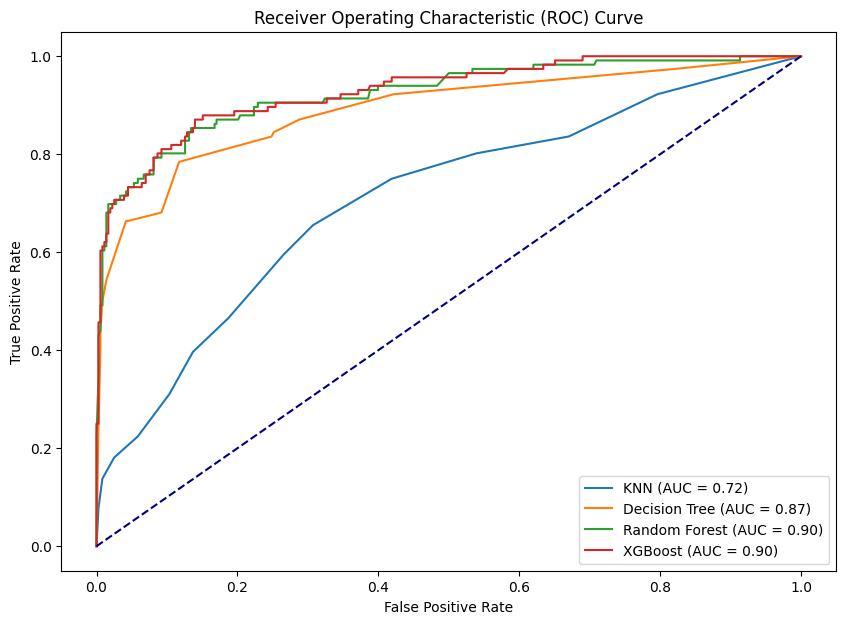

In [10]:
# RUN9
# This section will have less comments, since it has already be described in RUN1
# The features and target variable are extracted from the DF and stored in X and y, respectively.
X = df[['days_since_modified', 'AS_count', 'cone', 'relationship', 'only_asn', 'keyword_present']]
y = df['class']

# Define the classifiers to try
classifiers = {
    'KNN': KNeighborsClassifier,
    'Decision Tree': DecisionTreeClassifier,
    'Random Forest': RandomForestClassifier,
    'XGBoost': XGBClassifier
}

# Define the hyperparameter grids for each classifier
param_grids = {
    'KNN': {
        "n_neighbors": [3, 5, 7, 9, 11, 13],
        "weights": ['uniform', 'distance'],
        "metric": ['euclidean', 'manhattan']
    },
    'Decision Tree': {
        "max_depth": [5, 10, 15],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "criterion": ["gini", "entropy"]
    },
    'Random Forest': {
        "n_estimators": [100, 200, 300],
        "max_depth": [5, 10, 15],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "bootstrap": [True, False],
        "criterion": ["gini", "entropy"]
    },
    'XGBoost': {
        "n_estimators": [250, 260, 270, 300, 400],
        "max_depth": [5, 10, 15],
        "learning_rate": [0.01, 0.1, 0.2],
        "subsample": [0.5, 0.7, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0]
    }
}


# Define the outer cross-validation strategy
outer_cv = StratifiedKFold(n_splits=5)

# To store ROC curve data for plotting
roc_curve_data = {}

# Iterate through the classifiers
for classifier_name, Classifier in classifiers.items():
    param_grid = param_grids[classifier_name]
    
    # Create lists to hold the scores for each outer fold
    outer_accuracies = []
    outer_precisions = []
    outer_recalls = []
    outer_f1_scores = []
    outer_roc_aucs = []

    # Outer cross-validation loop
    for train_idx, test_idx in outer_cv.split(X, y):

        # Split the data into training and testing sets
        X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Define the inner cross-validation
        inner_cv = StratifiedKFold(n_splits=5)

        # Define the SMOTE object
        smote = SMOTE()

        # Define the pipeline with SMOTE and the classifier
        pipeline = Pipeline([
            ('smote', smote),
            ('classifier', Classifier() if classifier_name != 'XGBoost' else Classifier(eval_metric='logloss'))
        ])

        # Update the parameter grid to work with the pipeline
        param_grid_pipeline = {f"classifier__{key}": value for key, value in param_grid.items()}

        # Perform grid search with inner cross-validation, using all cores
        grid = GridSearchCV(
            pipeline,
            param_grid_pipeline, cv=inner_cv, scoring='recall', verbose=0, n_jobs=-1)

        # Fit the grid search object to the training data
        grid.fit(X_train, y_train)

        # Get the best parameters during inner cross-validation
        cv_best_parameters = {key.replace("classifier__", ""): value for key, value in grid.best_params_.items()}

        # Train the model using the best parameters
        best_model = Pipeline([
            ('smote', smote),
            ('classifier', Classifier(**cv_best_parameters) if classifier_name != 'XGBoost' else Classifier(eval_metric='logloss', **cv_best_parameters))
        ])
        best_model.fit(X_train, y_train)

        # Evaluate on the test set
        y_pred = best_model.predict(X_test)
        
        # Calculate performance metrics for the best model on the test set
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Calculate ROC AUC for the best model on the test set
        y_prob = best_model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob)

        # Store the scores for this outer fold
        outer_accuracies.append(accuracy)
        outer_precisions.append(precision)
        outer_recalls.append(recall)
        outer_f1_scores.append(f1)
        outer_roc_aucs.append(roc_auc)

    # Print the mean and standard deviation of the outer scores
    print(f"Results for {classifier_name}:")
    print("Best Parameters:", cv_best_parameters)  # Added line to print best parameters
    print("Mean accuracy:", np.mean(outer_accuracies))
    print("Mean precision:", np.mean(outer_precisions))
    print("Mean recall:", np.mean(outer_recalls))
    print("Mean F1-score:", np.mean(outer_f1_scores))
    print("Mean ROC AUC:", np.mean(outer_roc_aucs))
    
    # Store the mean ROC AUC for plotting
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_curve_data[classifier_name] = (fpr, tpr, np.mean(outer_roc_aucs))

# Plot the ROC curves
plt.figure(figsize=(10, 7))
for classifier_name, (fpr, tpr, roc_auc) in roc_curve_data.items():
    plt.plot(fpr, tpr, label=f'{classifier_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Results for KNN:
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}
Mean accuracy: 0.8472573839662447
Mean precision: 0.8623182930710502
Mean recall: 0.8472573839662447
Mean F1-score: 0.8473613694464408
Mean ROC AUC: 0.8755954053870498
Results for Decision Tree:
Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 5}
Mean accuracy: 0.8430379746835444
Mean precision: 0.8601869717817603
Mean recall: 0.8430379746835444
Mean F1-score: 0.8446530340057657
Mean ROC AUC: 0.8485028809376456
Results for Random Forest:
Best Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
Mean accuracy: 0.8734177215189873
Mean precision: 0.8834610996184298
Mean recall: 0.8734177215189873
Mean F1-score: 0.8724540477286953
Mean ROC AUC: 0.8917293004771325
Results for XGBoost:
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth'

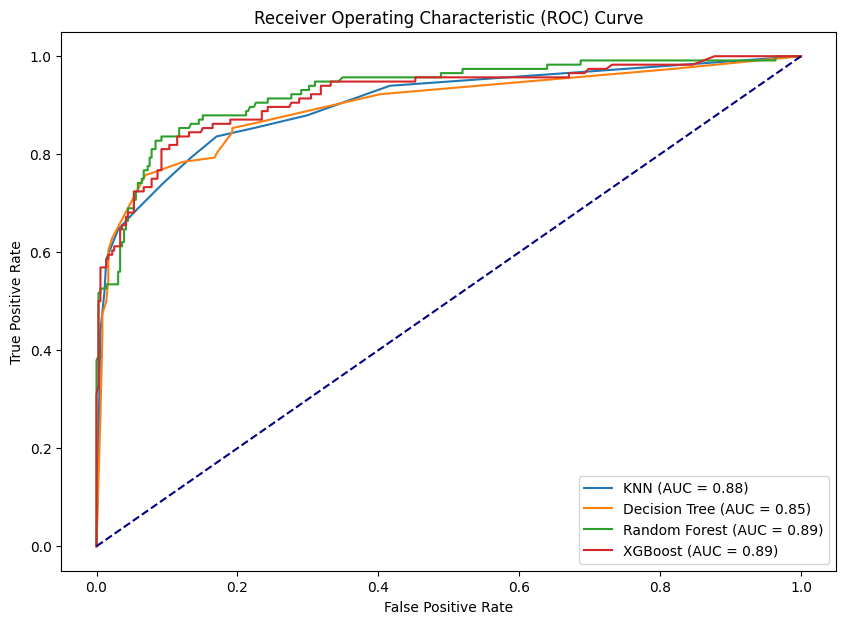

In [11]:
# RUN10
# This section will have less comments, since it has already be described in RUN1
# The features and target variable are extracted from the DF and stored in X and y, respectively.
X = df[['days_since_modified', 'AS_count', 'cone', 'relationship', 'only_asn', 'keyword_present']]
y = df['class']

# Define the scaler
scaler = QuantileTransformer()

# Define the classifiers to try
classifiers = {
    'KNN': KNeighborsClassifier,
    'Decision Tree': DecisionTreeClassifier,
    'Random Forest': RandomForestClassifier,
    'XGBoost': XGBClassifier
}

# Define the hyperparameter grids for each classifier
param_grids = {
    'KNN': {
        "n_neighbors": [3, 5, 7, 9, 11, 13],
        "weights": ['uniform', 'distance'],
        "metric": ['euclidean', 'manhattan']
    },
    'Decision Tree': {
        "max_depth": [5, 10, 15],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "criterion": ["gini", "entropy"]
    },
    'Random Forest': {
        "n_estimators": [100, 200, 300],
        "max_depth": [5, 10, 15],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "bootstrap": [True, False],
        "criterion": ["gini", "entropy"]
    },
    'XGBoost': {
        "n_estimators": [250, 260, 270, 300, 400],
        "max_depth": [5, 10, 15],
        "learning_rate": [0.01, 0.1, 0.2],
        "subsample": [0.5, 0.7, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0]
    }
}


# Define the outer cross-validation strategy
outer_cv = StratifiedKFold(n_splits=5)

# To store ROC curve data for plotting
roc_curve_data = {}

# Iterate through the classifiers
for classifier_name, Classifier in classifiers.items():
    param_grid = param_grids[classifier_name]
    
    # Create lists to hold the scores for each outer fold
    outer_accuracies = []
    outer_precisions = []
    outer_recalls = []
    outer_f1_scores = []
    outer_roc_aucs = []

    # Outer cross-validation loop
    for train_idx, test_idx in outer_cv.split(X, y):

        # Split the data into training and testing sets
        X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Scale only specific features
        X_train[['days_since_modified', 'AS_count', 'cone']] = scaler.fit_transform(X_train[['days_since_modified', 'AS_count', 'cone']])
        X_test[['days_since_modified', 'AS_count', 'cone']] = scaler.transform(X_test[['days_since_modified', 'AS_count', 'cone']])

        # Define the inner cross-validation
        inner_cv = StratifiedKFold(n_splits=5)

        # Define the SMOTE object
        smote = SMOTE()

        # Define the pipeline with SMOTE and the classifier
        pipeline = Pipeline([
            ('smote', smote),
            ('classifier', Classifier() if classifier_name != 'XGBoost' else Classifier(eval_metric='logloss'))
        ])

        # Update the parameter grid to work with the pipeline
        param_grid_pipeline = {f"classifier__{key}": value for key, value in param_grid.items()}

        # Perform grid search with inner cross-validation, using all cores
        grid = GridSearchCV(
            pipeline,
            param_grid_pipeline, cv=inner_cv, scoring='recall', verbose=0, n_jobs=-1)

        # Fit the grid search object to the training data
        grid.fit(X_train, y_train)

        # Get the best parameters during inner cross-validation
        cv_best_parameters = {key.replace("classifier__", ""): value for key, value in grid.best_params_.items()}

        # Train the model using the best parameters
        best_model = Pipeline([
            ('smote', smote),
            ('classifier', Classifier(**cv_best_parameters) if classifier_name != 'XGBoost' else Classifier(eval_metric='logloss', **cv_best_parameters))
        ])
        best_model.fit(X_train, y_train)

        # Evaluate on the test set
        y_pred = best_model.predict(X_test)
        
        # Calculate performance metrics for the best model on the test set
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Calculate ROC AUC for the best model on the test set
        y_prob = best_model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob)

        # Store the scores for this outer fold
        outer_accuracies.append(accuracy)
        outer_precisions.append(precision)
        outer_recalls.append(recall)
        outer_f1_scores.append(f1)
        outer_roc_aucs.append(roc_auc)

    # Print the mean and standard deviation of the outer scores
    print(f"Results for {classifier_name}:")
    print("Best Parameters:", cv_best_parameters)  # Added line to print best parameters
    print("Mean accuracy:", np.mean(outer_accuracies))
    print("Mean precision:", np.mean(outer_precisions))
    print("Mean recall:", np.mean(outer_recalls))
    print("Mean F1-score:", np.mean(outer_f1_scores))
    print("Mean ROC AUC:", np.mean(outer_roc_aucs))
    
    # Store the mean ROC AUC for plotting
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_curve_data[classifier_name] = (fpr, tpr, np.mean(outer_roc_aucs))

# Plot the ROC curves
plt.figure(figsize=(10, 7))
for classifier_name, (fpr, tpr, roc_auc) in roc_curve_data.items():
    plt.plot(fpr, tpr, label=f'{classifier_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Results for KNN:
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}
Mean accuracy: 0.8379746835443038
Mean precision: 0.8516070939805079
Mean recall: 0.8379746835443038
Mean F1-score: 0.8397836431113292
Mean ROC AUC: 0.8622974388181331
Results for Decision Tree:
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mean accuracy: 0.8594936708860759
Mean precision: 0.8709033355240134
Mean recall: 0.8594936708860759
Mean F1-score: 0.8599468178185944
Mean ROC AUC: 0.8577004698814596
Results for Random Forest:
Best Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
Mean accuracy: 0.8725738396624472
Mean precision: 0.8801708140812637
Mean recall: 0.8725738396624472
Mean F1-score: 0.8717008274765977
Mean ROC AUC: 0.8958429251823412
Results for XGBoost:
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_dep

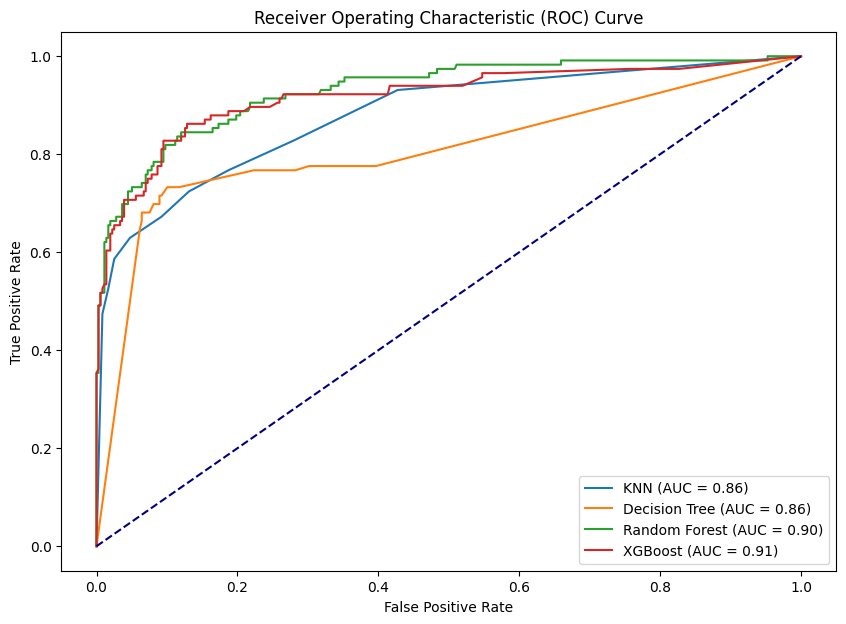

In [12]:
# RUN11
# This section will have less comments, since it has already be described in RUN1
# The features and target variable are extracted from the DF and stored in X and y, respectively.
X = df[['days_since_modified', 'AS_count', 'cone', 'relationship', 'only_asn', 'keyword_present']]
y = df['class']

# Define the classifiers to try
classifiers = {
    'KNN': KNeighborsClassifier,
    'Decision Tree': DecisionTreeClassifier,
    'Random Forest': RandomForestClassifier,
    'XGBoost': XGBClassifier
}

# Define the hyperparameter grids for each classifier
param_grids = {
    'KNN': {
        "n_neighbors": [3, 5, 7, 9, 11, 13],
        "weights": ['uniform', 'distance'],
        "metric": ['euclidean', 'manhattan']
    },
    'Decision Tree': {
        "max_depth": [5, 10, 15],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "criterion": ["gini", "entropy"]
    },
    'Random Forest': {
        "n_estimators": [100, 200, 300],
        "max_depth": [5, 10, 15],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "bootstrap": [True, False],
        "criterion": ["gini", "entropy"]
    },
    'XGBoost': {
        "n_estimators": [250, 260, 270, 300, 400],
        "max_depth": [5, 10, 15],
        "learning_rate": [0.01, 0.1, 0.2],
        "subsample": [0.5, 0.7, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0]
    }
}


# Define the outer cross-validation strategy
outer_cv = StratifiedKFold(n_splits=5)

# To store ROC curve data for plotting
roc_curve_data = {}

# Iterate through the classifiers
for classifier_name, Classifier in classifiers.items():
    param_grid = param_grids[classifier_name]
    
    # Create lists to hold the scores for each outer fold
    outer_accuracies = []
    outer_precisions = []
    outer_recalls = []
    outer_f1_scores = []
    outer_roc_aucs = []

    # Outer cross-validation loop
    for train_idx, test_idx in outer_cv.split(X, y):

        # Split the data into training and testing sets
        X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Apply log transform on specific features
        X_train[['days_since_modified', 'AS_count', 'cone']] = np.log1p(X_train[['days_since_modified', 'AS_count', 'cone']])
        X_test[['days_since_modified', 'AS_count', 'cone']] = np.log1p(X_test[['days_since_modified', 'AS_count', 'cone']])

        # Define the inner cross-validation
        inner_cv = StratifiedKFold(n_splits=5)

        # Define the SMOTE object
        smote = SMOTE()

        # Define the pipeline with SMOTE and the classifier
        pipeline = Pipeline([
            ('smote', smote),
            ('classifier', Classifier() if classifier_name != 'XGBoost' else Classifier(eval_metric='logloss'))
        ])

        # Update the parameter grid to work with the pipeline
        param_grid_pipeline = {f"classifier__{key}": value for key, value in param_grid.items()}

        # Perform grid search with inner cross-validation, using all cores
        grid = GridSearchCV(
            pipeline,
            param_grid_pipeline, cv=inner_cv, scoring='recall', verbose=0, n_jobs=-1)

        # Fit the grid search object to the training data
        grid.fit(X_train, y_train)

        # Get the best parameters during inner cross-validation
        cv_best_parameters = {key.replace("classifier__", ""): value for key, value in grid.best_params_.items()}

        # Train the model using the best parameters
        best_model = Pipeline([
            ('smote', smote),
            ('classifier', Classifier(**cv_best_parameters) if classifier_name != 'XGBoost' else Classifier(eval_metric='logloss', **cv_best_parameters))
        ])
        best_model.fit(X_train, y_train)

        # Evaluate on the test set
        y_pred = best_model.predict(X_test)
        
        # Calculate performance metrics for the best model on the test set
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Calculate ROC AUC for the best model on the test set
        y_prob = best_model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob)

        # Store the scores for this outer fold
        outer_accuracies.append(accuracy)
        outer_precisions.append(precision)
        outer_recalls.append(recall)
        outer_f1_scores.append(f1)
        outer_roc_aucs.append(roc_auc)

    # Print the mean and standard deviation of the outer scores
    print(f"Results for {classifier_name}:")
    print("Best Parameters:", cv_best_parameters)  # Added line to print best parameters
    print("Mean accuracy:", np.mean(outer_accuracies))
    print("Mean precision:", np.mean(outer_precisions))
    print("Mean recall:", np.mean(outer_recalls))
    print("Mean F1-score:", np.mean(outer_f1_scores))
    print("Mean ROC AUC:", np.mean(outer_roc_aucs))
    
    # Store the mean ROC AUC for plotting
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_curve_data[classifier_name] = (fpr, tpr, np.mean(outer_roc_aucs))

# Plot the ROC curves
plt.figure(figsize=(10, 7))
for classifier_name, (fpr, tpr, roc_auc) in roc_curve_data.items():
    plt.plot(fpr, tpr, label=f'{classifier_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Results for KNN:
Best Parameters: {'metric': 'euclidean', 'n_neighbors': 13, 'weights': 'uniform'}
Mean accuracy: 0.8421940928270043
Mean precision: 0.8555344272282618
Mean recall: 0.8421940928270043
Mean F1-score: 0.8440757989065129
Mean ROC AUC: 0.8669136410109942
Results for Decision Tree:
Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}
Mean accuracy: 0.8472573839662447
Mean precision: 0.8585180150773033
Mean recall: 0.8472573839662447
Mean F1-score: 0.8466198988861166
Mean ROC AUC: 0.8730395559716913
Results for Random Forest:
Best Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Mean accuracy: 0.8734177215189872
Mean precision: 0.8822012847323142
Mean recall: 0.8734177215189872
Mean F1-score: 0.8731084994614641
Mean ROC AUC: 0.8976376921403757
Results for XGBoost:
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_dept

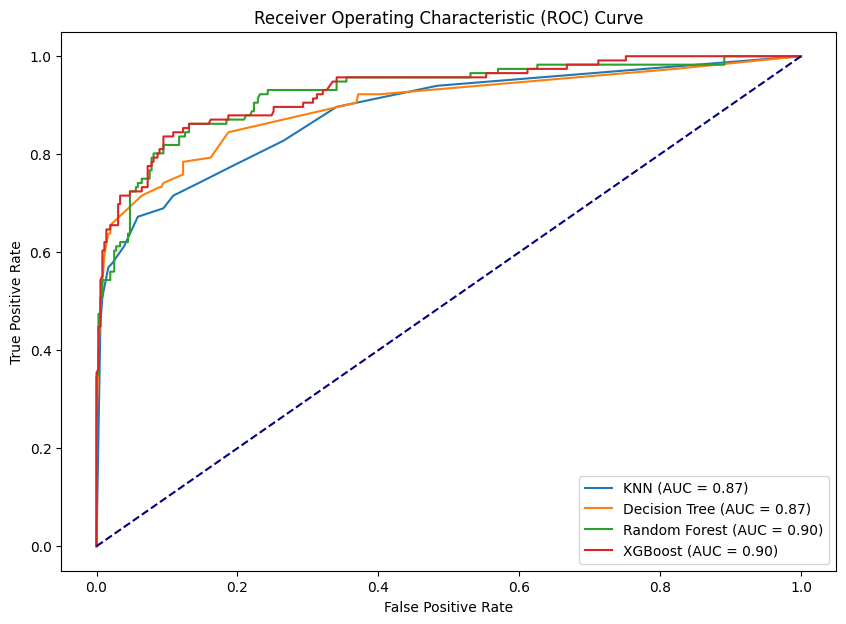

In [13]:
# RUN12
# This section will have less comments, since it has already be described in RUN1
# The features and target variable are extracted from the DF and stored in X and y, respectively.
X = df[['days_since_modified', 'AS_count', 'cone', 'relationship', 'only_asn', 'keyword_present']]
y = df['class']

# Define the scaler
scaler = PowerTransformer()

# Define the classifiers to try
classifiers = {
    'KNN': KNeighborsClassifier,
    'Decision Tree': DecisionTreeClassifier,
    'Random Forest': RandomForestClassifier,
    'XGBoost': XGBClassifier
}

# Define the hyperparameter grids for each classifier
param_grids = {
    'KNN': {
        "n_neighbors": [3, 5, 7, 9, 11, 13],
        "weights": ['uniform', 'distance'],
        "metric": ['euclidean', 'manhattan']
    },
    'Decision Tree': {
        "max_depth": [5, 10, 15],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "criterion": ["gini", "entropy"]
    },
    'Random Forest': {
        "n_estimators": [100, 200, 300],
        "max_depth": [5, 10, 15],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "bootstrap": [True, False],
        "criterion": ["gini", "entropy"]
    },
    'XGBoost': {
        "n_estimators": [250, 260, 270, 300, 400],
        "max_depth": [5, 10, 15],
        "learning_rate": [0.01, 0.1, 0.2],
        "subsample": [0.5, 0.7, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0]
    }
}


# Define the outer cross-validation strategy
outer_cv = StratifiedKFold(n_splits=5)

# To store ROC curve data for plotting
roc_curve_data = {}

# Iterate through the classifiers
for classifier_name, Classifier in classifiers.items():
    param_grid = param_grids[classifier_name]
    
    # Create lists to hold the scores for each outer fold
    outer_accuracies = []
    outer_precisions = []
    outer_recalls = []
    outer_f1_scores = []
    outer_roc_aucs = []

    # Outer cross-validation loop
    for train_idx, test_idx in outer_cv.split(X, y):

        # Split the data into training and testing sets
        X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Scale only specific features
        X_train[['days_since_modified', 'AS_count', 'cone']] = scaler.fit_transform(X_train[['days_since_modified', 'AS_count', 'cone']])
        X_test[['days_since_modified', 'AS_count', 'cone']] = scaler.transform(X_test[['days_since_modified', 'AS_count', 'cone']])

        # Define the inner cross-validation
        inner_cv = StratifiedKFold(n_splits=5)

        # Define the SMOTE object
        smote = SMOTE()

        # Define the pipeline with SMOTE and the classifier
        pipeline = Pipeline([
            ('smote', smote),
            ('classifier', Classifier() if classifier_name != 'XGBoost' else Classifier(eval_metric='logloss'))
        ])

        # Update the parameter grid to work with the pipeline
        param_grid_pipeline = {f"classifier__{key}": value for key, value in param_grid.items()}

        # Perform grid search with inner cross-validation, using all cores
        grid = GridSearchCV(
            pipeline,
            param_grid_pipeline, cv=inner_cv, scoring='recall', verbose=0, n_jobs=-1)

        # Fit the grid search object to the training data
        grid.fit(X_train, y_train)

        # Get the best parameters during inner cross-validation
        cv_best_parameters = {key.replace("classifier__", ""): value for key, value in grid.best_params_.items()}

        # Train the model using the best parameters
        best_model = Pipeline([
            ('smote', smote),
            ('classifier', Classifier(**cv_best_parameters) if classifier_name != 'XGBoost' else Classifier(eval_metric='logloss', **cv_best_parameters))
        ])
        best_model.fit(X_train, y_train)

        # Evaluate on the test set
        y_pred = best_model.predict(X_test)
        
        # Calculate performance metrics for the best model on the test set
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Calculate ROC AUC for the best model on the test set
        y_prob = best_model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob)

        # Store the scores for this outer fold
        outer_accuracies.append(accuracy)
        outer_precisions.append(precision)
        outer_recalls.append(recall)
        outer_f1_scores.append(f1)
        outer_roc_aucs.append(roc_auc)

    # Print the mean and standard deviation of the outer scores
    print(f"Results for {classifier_name}:")
    print("Best Parameters:", cv_best_parameters)  # Added line to print best parameters
    print("Mean accuracy:", np.mean(outer_accuracies))
    print("Mean precision:", np.mean(outer_precisions))
    print("Mean recall:", np.mean(outer_recalls))
    print("Mean F1-score:", np.mean(outer_f1_scores))
    print("Mean ROC AUC:", np.mean(outer_roc_aucs))
    
    # Store the mean ROC AUC for plotting
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_curve_data[classifier_name] = (fpr, tpr, np.mean(outer_roc_aucs))

# Plot the ROC curves
plt.figure(figsize=(10, 7))
for classifier_name, (fpr, tpr, roc_auc) in roc_curve_data.items():
    plt.plot(fpr, tpr, label=f'{classifier_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
#Here the 10 folds will be used for cross-validation

Results for KNN:
Best Parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Mean accuracy: 0.8738396624472573
Mean precision: 0.8752813004458124
Mean recall: 0.8738396624472573
Mean F1-score: 0.862663137602459
Mean ROC AUC: 0.8497707805494816
Results for Decision Tree:
Best Parameters: {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 10}
Mean accuracy: 0.8725738396624474
Mean precision: 0.8719786451880702
Mean recall: 0.8725738396624474
Mean F1-score: 0.8667472126332907
Mean ROC AUC: 0.8458949662840507
Results for Random Forest:
Best Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mean accuracy: 0.8793248945147679
Mean precision: 0.8828016087066104
Mean recall: 0.8793248945147679
Mean F1-score: 0.8697774557913751
Mean ROC AUC: 0.8920167881282006
Results for XGBoost:
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_de

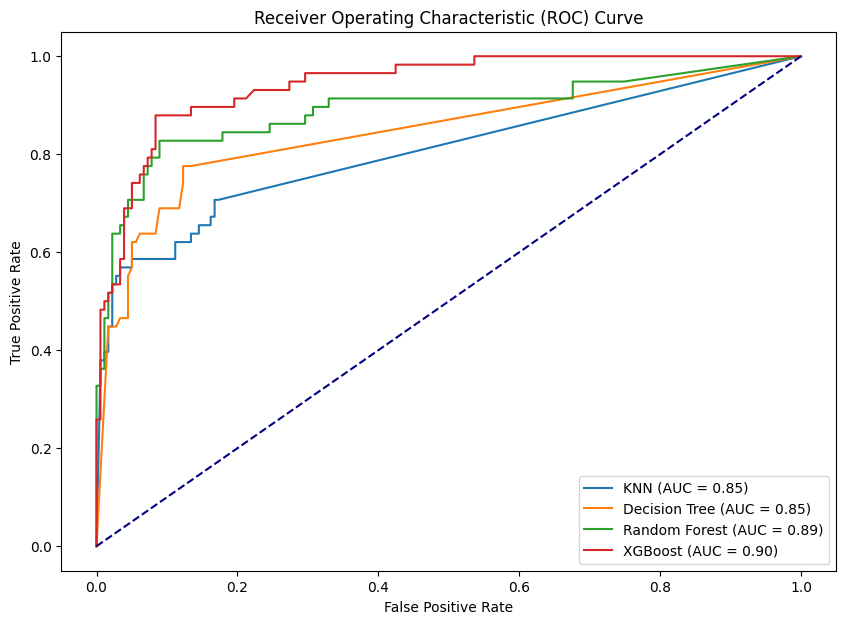

In [14]:
# RUN 13
# The features and target variable are extracted from the DF and stored in X and y, respectively.
X = df[['days_since_modified', 'AS_count', 'cone', 'relationship', 'only_asn', 'keyword_present']]
y = df['class']

# Define the transformer
transformer = PowerTransformer()

# Define the classifiers that would be used
classifiers = {
    'KNN': KNeighborsClassifier,
    'Decision Tree': DecisionTreeClassifier,
    'Random Forest': RandomForestClassifier,
    'XGBoost': XGBClassifier
}

# Define the hyperparameter grids for each classifier
param_grids = {
    'KNN': {
        "n_neighbors": [3, 5, 7, 9, 11, 13],
        "weights": ['uniform', 'distance'],
        "metric": ['euclidean', 'manhattan']
    },
    'Decision Tree': {
        "max_depth": [5, 10, 15],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "criterion": ["gini", "entropy"]
    },
    'Random Forest': {
        "n_estimators": [100, 200, 300],
        "max_depth": [5, 10, 15],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "bootstrap": [True, False],
        "criterion": ["gini", "entropy"]
    },
    'XGBoost': {
        "n_estimators": [250, 260, 270, 300, 400],
        "max_depth": [5, 10, 15],
        "learning_rate": [0.01, 0.1, 0.2],
        "subsample": [0.5, 0.7, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0]
    }
}

# Define the outer cross-validation loop
outer_cv = StratifiedKFold(n_splits=10)

# Here ROC curve data will be stored for plotting
roc_curve_data = {}

# Iterate through the classifiers
# For each classifier, the code goes through the outer cross-validation loop and evaluates the 
# model's performance on each outer fold using various metrics such as accuracy, precision, recall, F1-score, and ROC AUC.
for classifier_name, Classifier in classifiers.items():
    param_grid = param_grids[classifier_name]
    
    # Create lists to hold the scores for each outer fold
    outer_accuracies = []
    outer_precisions = []
    outer_recalls = []
    outer_f1_scores = []
    outer_roc_aucs = []

    # Outer cross-validation loop
    for train_idx, test_idx in outer_cv.split(X, y):

        # Split the data into training and testing sets
        X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Transform only 'days_since_modified', 'AS_count' and 'cone' features using specified transformer
        X_train[['days_since_modified', 'AS_count', 'cone']] = transformer.fit_transform(X_train[['days_since_modified', 'AS_count', 'cone']])
        X_test[['days_since_modified', 'AS_count', 'cone']] = transformer.transform(X_test[['days_since_modified', 'AS_count', 'cone']])

        # Define the inner cross-validation, where StratifiedKFold is used
        inner_cv = StratifiedKFold(n_splits=5)

        # Grid search (GridSearchCV) with inner cross-validation is performed to find the best hyperparameters for each classifier.
        # Here all cores will be used 
        grid = GridSearchCV(
            Classifier() if classifier_name != 'XGBoost' else Classifier(eval_metric='logloss'),
            param_grid, cv=inner_cv, scoring='recall', verbose=0, n_jobs=-1)

        # Fit the grid search object to the training data
        grid.fit(X_train, y_train)

        # Get the best parameters during inner cross-validation
        cv_best_parameters = grid.best_params_

        # Train the model using the best parameters
        best_model = Classifier(**cv_best_parameters) if classifier_name != 'XGBoost' else Classifier(eval_metric='logloss', **cv_best_parameters)
        best_model.fit(X_train, y_train)

        # Evaluate on the test set
        y_pred = best_model.predict(X_test)

        # Calculate performance metrics for the best model on the test set
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Calculate ROC AUC for the best model on the test set
        y_prob = best_model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob)

        # Store the scores for this outer fold
        outer_accuracies.append(accuracy)
        outer_precisions.append(precision)
        outer_recalls.append(recall)
        outer_f1_scores.append(f1)
        outer_roc_aucs.append(roc_auc)

    # Print the mean and standard deviation of the outer scores
    print(f"Results for {classifier_name}:")
    print("Best Parameters:", cv_best_parameters)
    print("Mean accuracy:", np.mean(outer_accuracies))
    print("Mean precision:", np.mean(outer_precisions))
    print("Mean recall:", np.mean(outer_recalls))
    print("Mean F1-score:", np.mean(outer_f1_scores))
    print("Mean ROC AUC:", np.mean(outer_roc_aucs))
    
    
    # Store the mean ROC AUC for plotting
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_curve_data[classifier_name] = (fpr, tpr, np.mean(outer_roc_aucs))
    
# Plot the ROC curves
plt.figure(figsize=(10, 7))
for classifier_name, (fpr, tpr, roc_auc) in roc_curve_data.items():
    plt.plot(fpr, tpr, label=f'{classifier_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Results for KNN:
Best Parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
Mean accuracy: 0.8333333333333334
Mean precision: 0.8507980828354054
Mean recall: 0.8333333333333334
Mean F1-score: 0.8374241560187519
Mean ROC AUC: 0.8692516587601198
Results for Decision Tree:
Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
Mean accuracy: 0.8421940928270042
Mean precision: 0.8589867092872584
Mean recall: 0.8421940928270042
Mean F1-score: 0.8460965915104893
Mean ROC AUC: 0.8490910944606105
Results for Random Forest:
Best Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Mean accuracy: 0.8599156118143461
Mean precision: 0.8739425714543596
Mean recall: 0.8599156118143461
Mean F1-score: 0.8627461362411666
Mean ROC AUC: 0.8982646134053429
Results for XGBoost:
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_dept

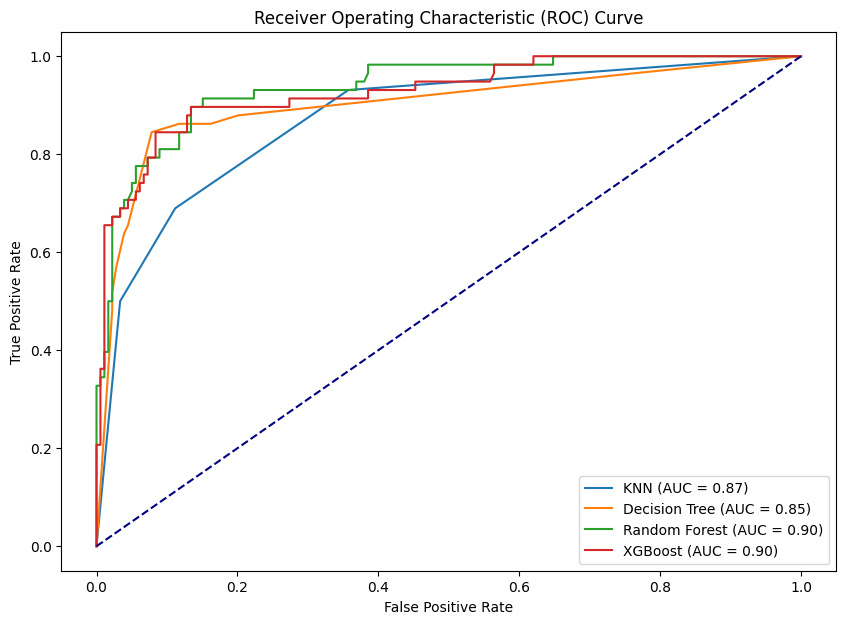

In [15]:
# RUN14
# This section will have less comments, since it has already be described in RUN1
# The features and target variable are extracted from the DF and stored in X and y, respectively.
X = df[['days_since_modified', 'AS_count', 'cone', 'relationship', 'only_asn', 'keyword_present']]
y = df['class']

# Define the scaler
scaler = QuantileTransformer()

# Define the classifiers to try
classifiers = {
    'KNN': KNeighborsClassifier,
    'Decision Tree': DecisionTreeClassifier,
    'Random Forest': RandomForestClassifier,
    'XGBoost': XGBClassifier
}

# Define the hyperparameter grids for each classifier
param_grids = {
    'KNN': {
        "n_neighbors": [3, 5, 7, 9, 11, 13],
        "weights": ['uniform', 'distance'],
        "metric": ['euclidean', 'manhattan']
    },
    'Decision Tree': {
        "max_depth": [5, 10, 15],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "criterion": ["gini", "entropy"]
    },
    'Random Forest': {
        "n_estimators": [100, 200, 300],
        "max_depth": [5, 10, 15],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "bootstrap": [True, False],
        "criterion": ["gini", "entropy"]
    },
    'XGBoost': {
        "n_estimators": [250, 260, 270, 300, 400],
        "max_depth": [5, 10, 15],
        "learning_rate": [0.01, 0.1, 0.2],
        "subsample": [0.5, 0.7, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0]
    }
}



# Define the outer cross-validation strategy
outer_cv = StratifiedKFold(n_splits=10)

# To store ROC curve data for plotting
roc_curve_data = {}

# Iterate through the classifiers
for classifier_name, Classifier in classifiers.items():
    param_grid = param_grids[classifier_name]
    
    # Create lists to hold the scores for each outer fold
    outer_accuracies = []
    outer_precisions = []
    outer_recalls = []
    outer_f1_scores = []
    outer_roc_aucs = []

    # Outer cross-validation loop
    for train_idx, test_idx in outer_cv.split(X, y):

        # Split the data into training and testing sets
        X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Scale only specific features
        X_train[['days_since_modified', 'AS_count', 'cone']] = scaler.fit_transform(X_train[['days_since_modified', 'AS_count', 'cone']])
        X_test[['days_since_modified', 'AS_count', 'cone']] = scaler.transform(X_test[['days_since_modified', 'AS_count', 'cone']])

        # Define the inner cross-validation
        inner_cv = StratifiedKFold(n_splits=5)

        # Define the undersampler
        undersampler = RandomUnderSampler()

        # Define the pipeline with undersampling and the classifier
        pipeline = Pipeline([
            ('undersample', undersampler),
            ('classifier', Classifier() if classifier_name != 'XGBoost' else Classifier(eval_metric='logloss'))
        ])

        # Update the parameter grid to work with the pipeline
        param_grid_pipeline = {f"classifier__{key}": value for key, value in param_grid.items()}

        # Perform grid search with inner cross-validation, using all cores
        grid = GridSearchCV(
            pipeline,
            param_grid_pipeline, cv=inner_cv, scoring='recall', verbose=0, n_jobs=-1)

        # Fit the grid search object to the training data
        grid.fit(X_train, y_train)

        # Get the best parameters during inner cross-validation
        cv_best_parameters = {key.replace("classifier__", ""): value for key, value in grid.best_params_.items()}

        # Train the model using the best parameters
        best_model = Pipeline([
            ('undersample', undersampler),
            ('classifier', Classifier(**cv_best_parameters) if classifier_name != 'XGBoost' else Classifier(eval_metric='logloss', **cv_best_parameters))
        ])
        best_model.fit(X_train, y_train)

        # Evaluate on the test set
        y_pred = best_model.predict(X_test)
        
        # Calculate performance metrics for the best model on the test set
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Calculate ROC AUC for the best model on the test set
        y_prob = best_model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob)

        # Store the scores for this outer fold
        outer_accuracies.append(accuracy)
        outer_precisions.append(precision)
        outer_recalls.append(recall)
        outer_f1_scores.append(f1)
        outer_roc_aucs.append(roc_auc)

    # Print the mean and standard deviation of the outer scores
    print(f"Results for {classifier_name}:")
    print("Best Parameters:", cv_best_parameters)  # Added line to print best parameters
    print("Mean accuracy:", np.mean(outer_accuracies))
    print("Mean precision:", np.mean(outer_precisions))
    print("Mean recall:", np.mean(outer_recalls))
    print("Mean F1-score:", np.mean(outer_f1_scores))
    print("Mean ROC AUC:", np.mean(outer_roc_aucs))
    
    # Store the mean ROC AUC for plotting
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_curve_data[classifier_name] = (fpr, tpr, np.mean(outer_roc_aucs))

# Plot the ROC curves
plt.figure(figsize=(10, 7))
for classifier_name, (fpr, tpr, roc_auc) in roc_curve_data.items():
    plt.plot(fpr, tpr, label=f'{classifier_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Results for KNN:
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}
Mean accuracy: 0.8430379746835441
Mean precision: 0.8565306809583314
Mean recall: 0.8430379746835441
Mean F1-score: 0.8447856704301667
Mean ROC AUC: 0.8597217881621116
Results for Decision Tree:
Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}
Mean accuracy: 0.8873417721518987
Mean precision: 0.8892040218957652
Mean recall: 0.8873417721518987
Mean F1-score: 0.8839007473755164
Mean ROC AUC: 0.8768307673632411
Results for Random Forest:
Best Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Mean accuracy: 0.8751054852320674
Mean precision: 0.8847214789652101
Mean recall: 0.8751054852320674
Mean F1-score: 0.8738696679135625
Mean ROC AUC: 0.8963429289502398
Results for XGBoost:
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_dept

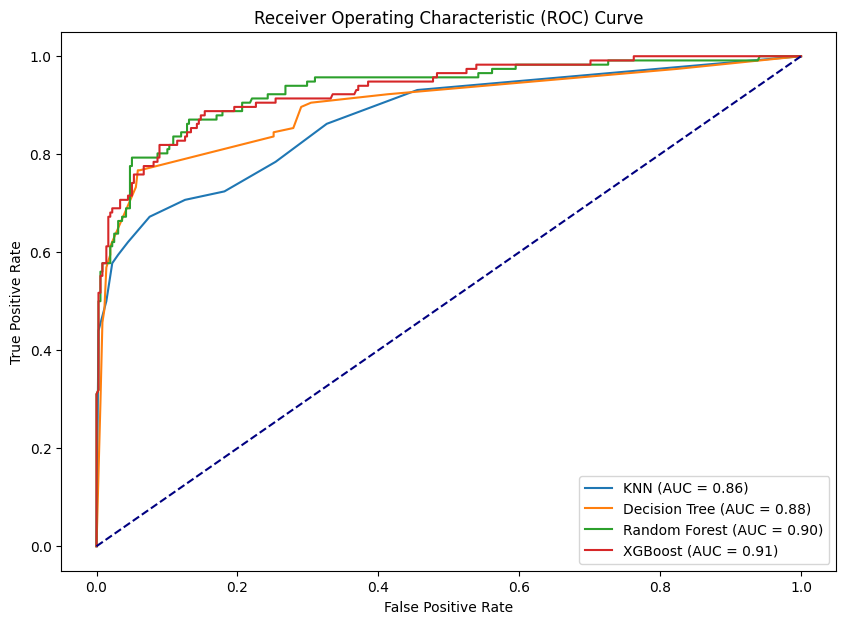

In [4]:
# RUN15
# This section will have less comments, since it has already be described in RUN1
# The features and target variable are extracted from the DF and stored in X and y, respectively.
X = df[['days_since_modified', 'AS_count', 'cone', 'relationship', 'only_asn', 'keyword_present']]
y = df['class']

# Define the classifiers to try
classifiers = {
    'KNN': KNeighborsClassifier,
    'Decision Tree': DecisionTreeClassifier,
    'Random Forest': RandomForestClassifier,
    'XGBoost': XGBClassifier
}

# Define the hyperparameter grids for each classifier
param_grids = {
    'KNN': {
        "n_neighbors": [3, 5, 7, 9, 11, 13],
        "weights": ['uniform', 'distance'],
        "metric": ['euclidean', 'manhattan']
    },
    'Decision Tree': {
        "max_depth": [5, 10, 15],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "criterion": ["gini", "entropy"]
    },
    'Random Forest': {
        "n_estimators": [100, 200, 300],
        "max_depth": [5, 10, 15],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "bootstrap": [True, False],
        "criterion": ["gini", "entropy"]
    },
    'XGBoost': {
        "n_estimators": [250, 260, 270, 300, 400],
        "max_depth": [5, 10, 15],
        "learning_rate": [0.01, 0.1, 0.2],
        "subsample": [0.5, 0.7, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0]
    }
}


# Define the outer cross-validation strategy
outer_cv = StratifiedKFold(n_splits=5)

# To store ROC curve data for plotting
roc_curve_data = {}

# Iterate through the classifiers
for classifier_name, Classifier in classifiers.items():
    param_grid = param_grids[classifier_name]
    
    # Create lists to hold the scores for each outer fold
    outer_accuracies = []
    outer_precisions = []
    outer_recalls = []
    outer_f1_scores = []
    outer_roc_aucs = []

    # Outer cross-validation loop
    for train_idx, test_idx in outer_cv.split(X, y):

        # Split the data into training and testing sets
        X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Apply log transform on specific features
        X_train[['days_since_modified', 'AS_count', 'cone']] = np.log1p(X_train[['days_since_modified', 'AS_count', 'cone']])
        X_test[['days_since_modified', 'AS_count', 'cone']] = np.log1p(X_test[['days_since_modified', 'AS_count', 'cone']])

        # Define the inner cross-validation
        inner_cv = StratifiedKFold(n_splits=10)

        # Define the SMOTE object
        smote = SMOTE()

        # Define the pipeline with SMOTE and the classifier
        pipeline = Pipeline([
            ('smote', smote),
            ('classifier', Classifier() if classifier_name != 'XGBoost' else Classifier(eval_metric='logloss'))
        ])

        # Update the parameter grid to work with the pipeline
        param_grid_pipeline = {f"classifier__{key}": value for key, value in param_grid.items()}

        # Perform grid search with inner cross-validation, using all cores
        grid = GridSearchCV(
            pipeline,
            param_grid_pipeline, cv=inner_cv, scoring='recall', verbose=0, n_jobs=-1)

        # Fit the grid search object to the training data
        grid.fit(X_train, y_train)

        # Get the best parameters during inner cross-validation
        cv_best_parameters = {key.replace("classifier__", ""): value for key, value in grid.best_params_.items()}

        # Train the model using the best parameters
        best_model = Pipeline([
            ('smote', smote),
            ('classifier', Classifier(**cv_best_parameters) if classifier_name != 'XGBoost' else Classifier(eval_metric='logloss', **cv_best_parameters))
        ])
        best_model.fit(X_train, y_train)

        # Evaluate on the test set
        y_pred = best_model.predict(X_test)
        
        # Calculate performance metrics for the best model on the test set
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Calculate ROC AUC for the best model on the test set
        y_prob = best_model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob)

        # Store the scores for this outer fold
        outer_accuracies.append(accuracy)
        outer_precisions.append(precision)
        outer_recalls.append(recall)
        outer_f1_scores.append(f1)
        outer_roc_aucs.append(roc_auc)

    # Print the mean and standard deviation of the outer scores
    print(f"Results for {classifier_name}:")
    print("Best Parameters:", cv_best_parameters)  # Added line to print best parameters
    print("Mean accuracy:", np.mean(outer_accuracies))
    print("Mean precision:", np.mean(outer_precisions))
    print("Mean recall:", np.mean(outer_recalls))
    print("Mean F1-score:", np.mean(outer_f1_scores))
    print("Mean ROC AUC:", np.mean(outer_roc_aucs))
    
    # Store the mean ROC AUC for plotting
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_curve_data[classifier_name] = (fpr, tpr, np.mean(outer_roc_aucs))

# Plot the ROC curves
plt.figure(figsize=(10, 7))
for classifier_name, (fpr, tpr, roc_auc) in roc_curve_data.items():
    plt.plot(fpr, tpr, label=f'{classifier_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()